**Персональные предложения покупателям**

**Задачи:**

1. построить модель для предсказания вероятности снижения покупательской активности;
2. выделить сегменты клиентов и разработать персональные предложения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import rcParams
import random
import seaborn as sns
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.metrics import ( 
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import re
import warnings
from imblearn.combine import SMOTETomek
import shap

try:
    import phik 
    from phik import phik_matrix
    from phik.report import plot_correlation_matrix

except:
    !pip install phik


# вывод всех столбцов и строк, независимо от их количества.
pd.set_option('display.max_columns', None)

# отключаем предупреждение
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# Загрузка данных

## Загрузим данные

In [2]:
try:
    market_file = pd.read_csv(
        r'...\market_file.csv')
    market_money = pd.read_csv(
        r'...\market_money.csv')
    market_time = pd.read_csv(
        r'...\market_time.csv')
    money = pd.read_csv(
        r'...\money.csv')
except:
    market_file = pd.read_csv('.../market_file.csv')
    market_money = pd.read_csv('.../market_money.csv')
    market_time = pd.read_csv('.../market_time.csv')
    money = pd.read_csv('.../money.csv')

In [3]:
display(market_file.head())

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [4]:
display(market_money.head())

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [5]:
display(market_time.head())

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [6]:
money.head()

id;Прибыль
215348;0        98.0
215349;4        16.0
215350;3        13.0
215351;4        87.0
215352;4        21.0

Данные в таблице `money.csv` склеились, применим `sep=';'` и разделим десятичные числа точкой `decimal=','`

In [7]:
try:
    market_file = pd.read_csv(
        r'...\market_file.csv')
    market_money = pd.read_csv(
        r'...\market_money.csv')
    market_time = pd.read_csv(
        r'...\market_time.csv')
    money = pd.read_csv(
        r'...\money.csv', 
        decimal=',', 
        sep=';'
    )
except:
    market_file = pd.read_csv('.../market_file.csv')
    market_money = pd.read_csv('.../market_money.csv')
    market_time = pd.read_csv('.../market_time.csv')
    money = pd.read_csv('.../money.csv',
                        decimal=',',
                        sep=';'
                       )

In [8]:
display(money.head())

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

## Проверка таблиц на соответствие описанию

In [9]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [11]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [12]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Все данные соответствуют техническому описанием.

# Предобработка данных

Подготовка данных для анализа называется предобработкой. Нужно оценить масштаб найденных проблем и 
устранить их. Предобработка следует принципу GIGO (от англ. garbage in — garbage out, буквально «мусор на входе — мусор на выходе»). Это значит, что при ошибках во входных данных даже правильный алгоритм работы приведёт к неверным результатам. Так же нужно помнить об законе экономии, который называется **Бри́тва О́ккама**. В нем говорится следующее: *Не следует множить сущее без необходимости.* Суть принципа: совершенство должно быть простым. Если какого-то результата можно достичь с привлечением сущностей A, B и C либо другим путём с привлечением A, B, С и D — надо выбирать первый путь. В плане программирования это значит, что не следут создавать промежуточные переменные, которые не пригодяться в дальнейшем.

## Изучим общую информацию о каждом датафрейме

In [13]:
display(market_file.head())

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

После просмотра общей информации ясно следующее:

- названия столбцов можно привести к змеиному регистру;
- данные в столбцах *Маркет_актив_6_мес, Маркет_актив_тек_мес, Акционные_покупки* предствленны в виде `object`, можно преобразовать в тип `float64`;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

In [14]:
display(market_money.head())

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

После просмотра общей информации ясно следующее:

- названия столбцов можно привести к змеиному регистру;
- данные в столбе *Выручка* предствленны в виде `object`, можно преобразовать в тип `float64`;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

In [15]:
display(market_time.head())

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

После просмотра общей информации ясно следующее:

- названия столбцов можно привести к змеиному регистру;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

In [16]:
display(money.head())

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

После просмотра общей информации ясно следующее:

- названия столбцов можно привести к змеиному регистру;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

## Вывод

После изучения общей информации о данных ясно следующее.

Датафрейм market_file:
- названия столбцов можно привести к змеиному регистру;
- данные в столбцах *Маркет_актив_6_мес, Маркет_актив_тек_мес, Акционные_покупки* предствленны в виде `object`, можно преобразовать в тип `float64`;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

Датафрейм market_money:
- названия столбцов можно привести к змеиному регистру;
- данные в столбе *Выручка* предствленны в виде `object`, можно преобразовать в тип `float64`;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

Датафрейм market_time:
- названия столбцов можно привести к змеиному регистру;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

Датафрейм money:
- названия столбцов можно привести к змеиному регистру;
- количество записей в столбцах датафрейма совпадат, пропуски отсутствуют.

In [17]:
# сохраним количество сырых данных
market_file_stok = market_file.shape[0]
market_money_stok = market_money.shape[0]
market_time_stok = market_time.shape[0]
money_stok = money.shape[0]

## Изменим данные

In [18]:
market_file.columns = [
    re.sub(
        r'(?<!^)(?=[A-Z])(?=[А-Я])', 
        '_', i
    )
    .lower()
    .replace(' ', '_') for i in market_file.columns
]

In [19]:
market_money.columns = [re.sub(r'(?<!^)(?=[A-Z])(?=[А-Я])', '_', i).lower().replace(' ', '_') for i in market_money.columns]

In [20]:
market_time.columns = [re.sub(r'(?<!^)(?=[A-Z])(?=[А-Я])', '_', i).lower().replace(' ', '_') for i in market_time.columns]

In [21]:
money.columns = [re.sub(r'(?<!^)(?=[A-Z])(?=[А-Я])', '_', i).lower().replace(' ', '_') for i in money.columns]

In [22]:
# к формату float
market_file[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки']] = (
    market_file[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки']]
    .astype(float)
)

# к формату float
market_money['выручка'] = market_money['выручка'].astype(float)

market_time.период.unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [23]:
# исправим опечатку
market_time.период = market_time.период.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [24]:
# закодируем целевой признак, 0 - Текущий уровень, 1 - Снизилась
market_file.покупательская_активность = (market_file
                                         .покупательская_активность
                                         .replace('Прежний уровень', 0)
                                         .replace('Снизилась', 1)
                                        )

## Проверка дупликатов

In [25]:
market_file.тип_сервиса.unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [26]:
# исправим дупликаты
market_file.тип_сервиса = market_file.тип_сервиса.replace('стандартт', 'стандарт')

In [33]:
market_file.популярная_категория.unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [34]:
# исправим опечатку
market_file.популярная_категория = market_file.популярная_категория.replace('Косметика и аксесуары', 'Косметика и аксессуары')

In [35]:
market_file.популярная_категория.unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [27]:
# сводная таблица параметров market_file
(market_file[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
             'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
             'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
             'страниц_за_визит']]
.apply(['count', 'std', 'min', 'mean', 'median', 'max'])   
.style.format("{:,.2f}"))

Данные выглядят адекватно

In [28]:
# сводная таблица параметров market_money
(market_money[['выручка']]
.apply(['count', 'std', 'min', 'mean', 'median', 'max'])   
.style.format("{:,.2f}"))

Выделяется максимальное значение 106 862, рассмотрим подробнее

In [29]:
market_money.query('выручка >= 8000')

id         период   выручка
98  215380  текущий_месяц  106862.2

98 строка - аномалия, отфильтруем после объединения данных в общий датафрейм

In [30]:
# сводная таблица параметров market_time
(market_time[['минут']]
.apply(['count', 'std', 'min', 'mean', 'median', 'max'])   
.style.format("{:,.2f}"))

Данные выглядят адекватно

In [31]:
# сводная таблица параметров money
(money[['прибыль']]
.apply(['count', 'std', 'min', 'mean', 'median', 'max'])   
.style.format("{:,.2f}"))

Данные выглядят адекватно

## Вывод

После предобработки данные пригодны для дальнейшего использования:

- удалили дупликаты,
- исправили названия столбцов,
- изменили формат данных в стоблцах для оптимизации,
- удалили аномалию,
- исправили опечатку,
- потери после предобработки примерно 0.1%.

# Исследовательский анализ данных

Исследовательский анализ данных является важным этапом в аналитике, который позволяет лучше понять данные и выявить основные 
характеристики и закономерности. Опишем и визуализируем общую информацию.

Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

В представленных данных есть следующие признаки: целевой (прогнозируемый) и входные (прогнозирующие) признаки.

Целевой категориальный:
- покупательская активность.

Входные количественные:
- маркет_актив_6_мес,
- маркет_актив_тек_мес,
- длительность,
- акционные_покупки,
- средний_просмотр_категорий_за_визит,
- неоплаченные_продукты_штук_квартал,
- ошибка_сервиса,
- страниц_за_визит,
- выручка,
- минут,
- прибыль.

Входные категиальные:
- тип_сервиса,
- разрешить_сообщать,
- популярная_категория,
- период.

## График целевого признака

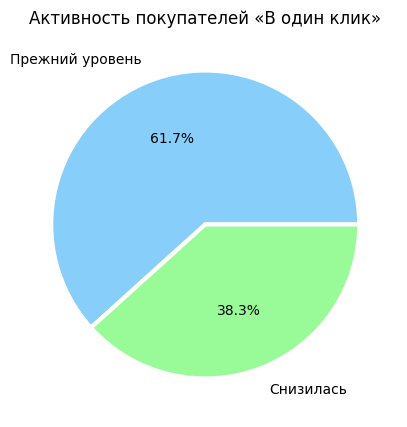

In [36]:
# диаграмма покупательская_активность
plt.rcParams["figure.figsize"] = (25,5)
fig, ax = plt.subplots()
ax.pie(market_file.покупательская_активность.value_counts(), 
       labels=('Прежний уровень', 'Снизилась'),
       autopct='%1.1f%%', labeldistance=1.15,
       wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
       colors=['lightskyblue', 'palegreen'])
plt.title('Активность покупателей «В один клик»')
plt.show()

## Графики входящих признаков

### Количественные признаки

In [37]:
# собственная функцция с генерацией случайного цвета
def hist_box_num_sub(data, x, title_hist, xlabel, ylabel):

    # создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # уникальные категории
    categories = market_file.покупательская_активность.unique()

    # случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}
    colors_box = {cat: random_color() for cat in categories}

    # Инициализация объекта Figure и создания подграфиков
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # гистограмма
    sns.histplot(data=data, 
                 x=x, 
                 hue='покупательская_активность',
                 palette=colors_hist,
                 ax=axes[0], 
                 kde=True
                )
    axes[0].set_title(title_hist,  fontsize=9)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    
    # boxplot
    sns.boxplot(data=data, 
                x=x, 
                hue='покупательская_активность',
                palette=colors_box,
                ax=axes[1]
               )
    axes[1].set_title('Ящик с усами колическтвенного признака',  fontsize=9)
    axes[1].set_xlabel(xlabel)
    axes[1].legend(title='покупательская_активность', loc='upper left')

    plt.tight_layout()
    plt.show()

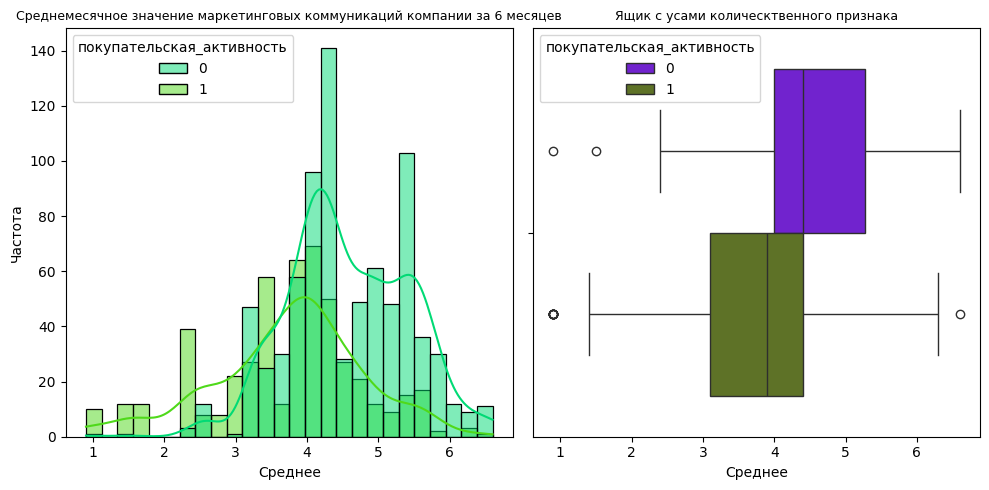

In [38]:
# маркет_актив_6_мес
hist_box_num_sub(
    market_file, 
    'маркет_актив_6_мес', 
    'Среднемесячное значение маркетинговых коммуникаций компании за 6 месяцев', 
    'Среднее', 
    'Частота'
)

Присутствуют выбросы у *Снизилать* до 1.75 от 6.5 и *Прежний уровень до 1.6*. У покупателей с сниженной активностью меньше коммуникаций с компанией.

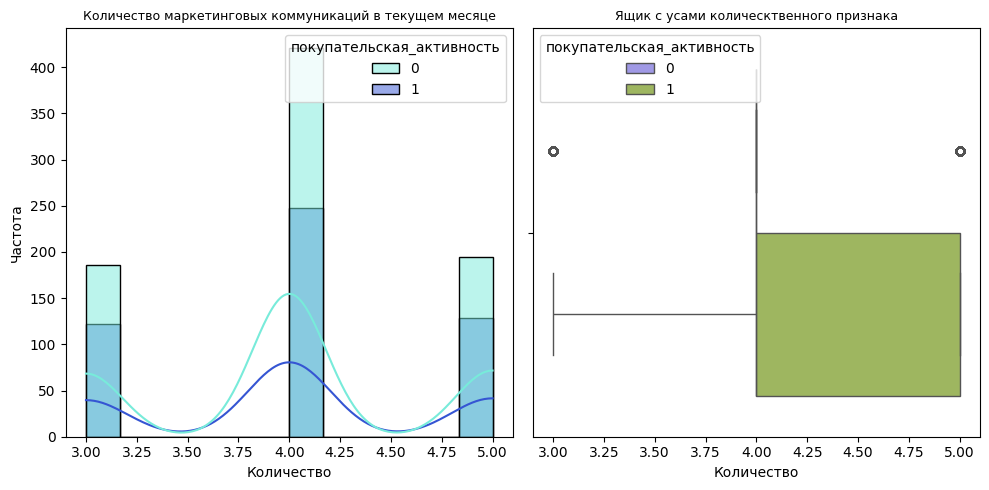

In [39]:
# маркет_актив_тек_мес
hist_box_num_sub(
    market_file,
    'маркет_актив_тек_мес',
    'Количество маркетинговых коммуникаций в текущем месяце',
    'Количество', 
    'Частота'
)

Присутствуют выбросы у *Прежний уровень до 3.1 от 4.9*. По графикам заметно, что компания взаимодействовала в текущем месяце с клиентами с сниженной активность меньше, чем с клиентами с прежним уровнем. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего на каждого клиента.

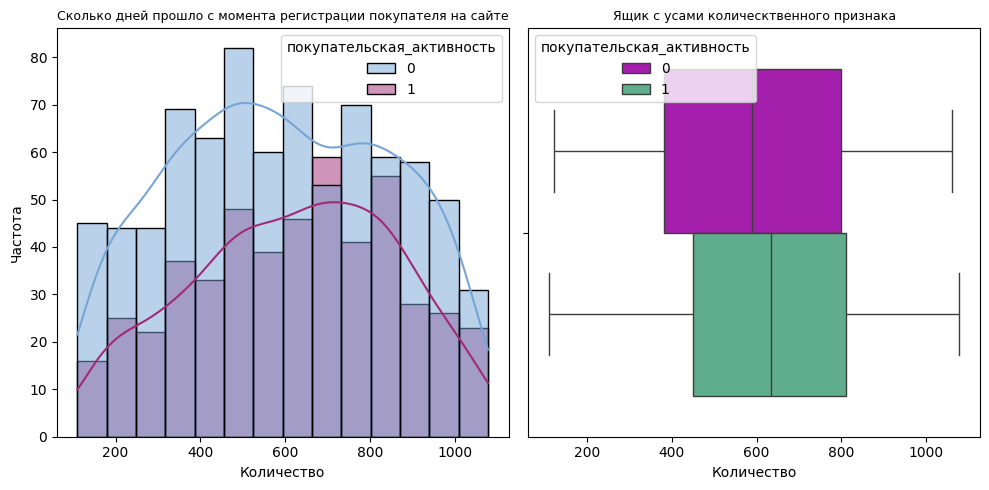

In [40]:
# длительность
hist_box_num_sub(
    market_file,
    'длительность',
    'Сколько дней прошло с момента регистрации покупателя на сайте',
    'Количество', 
    'Частота'
)

Здесь аналогично, клиенты с сниженной активностью не так давно зарегистрированы на сайте.

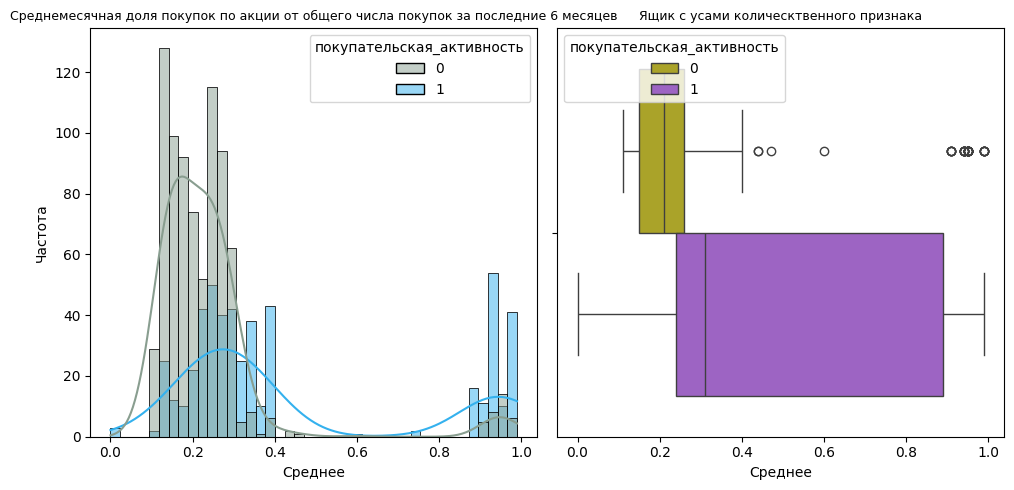

In [41]:
# акционные_покупки
hist_box_num_sub(
    market_file,
    'акционные_покупки',
    'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев',
    'Среднее', 
    'Частота'
)

Присутствуют выбросы у *Прежний уровень* от 0.41. Клиенты с сниженной активностью за последние 6 месяцев меньше учавствовали 
в акцонных покупках. В районе единицы у группы снижена активность всплеск показателей, возможно была распрадажа или большая акция на товары.

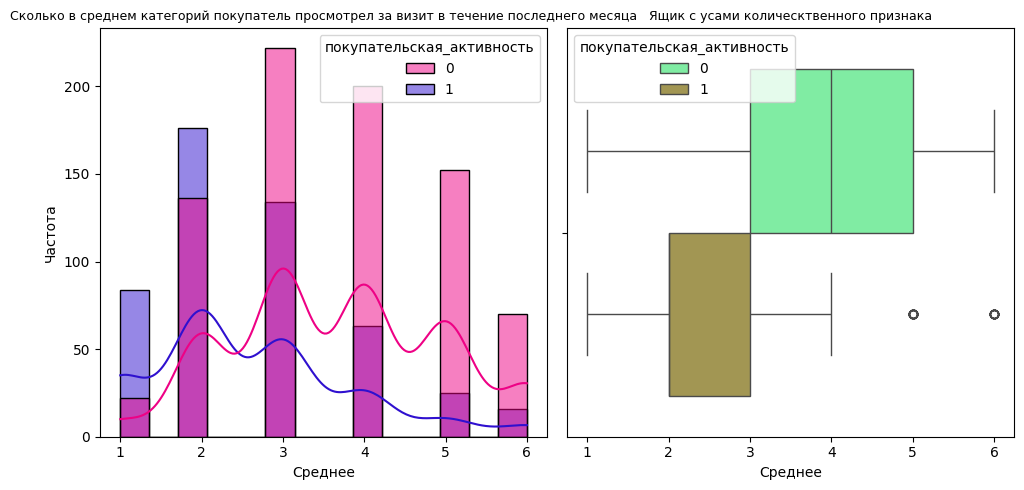

In [42]:
# средний_просмотр_категорий_за_визит
hist_box_num_sub(
    market_file,
    'средний_просмотр_категорий_за_визит',
    'Сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца',
    'Среднее', 
    'Частота'
)

Присутствуют выбросы у *Снизилать* от 5. У категории снизилась меньше среднее просмотра

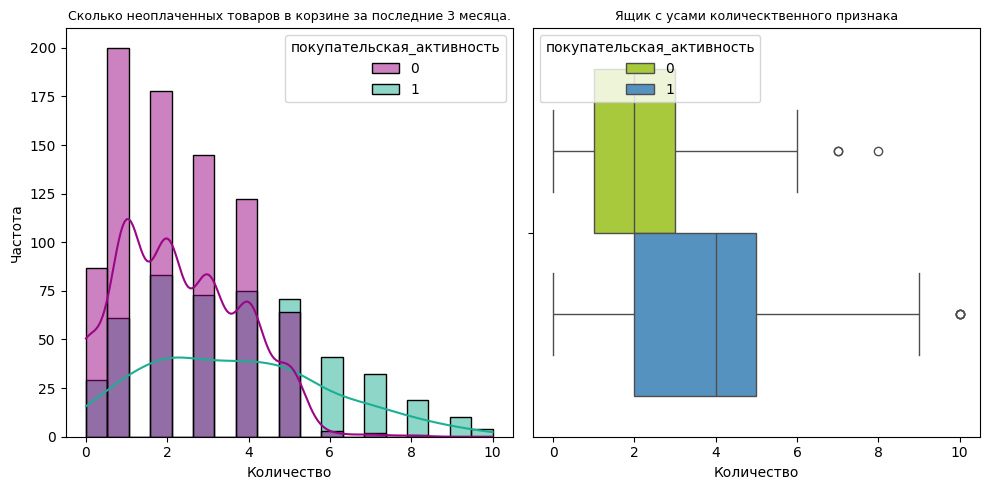

In [43]:
# неоплаченные_продукты_штук_квартал
hist_box_num_sub(
    market_file,
    'неоплаченные_продукты_штук_квартал',
    'Сколько неоплаченных товаров в корзине за последние 3 месяца.',
    'Количество', 
    'Частота'
)

Присутствуют выбросы у *Снизилать* от 9 и *Прежний уровень от 7*. Логично, что у тех кто меньше покупает, меньше неоплаченых товаров

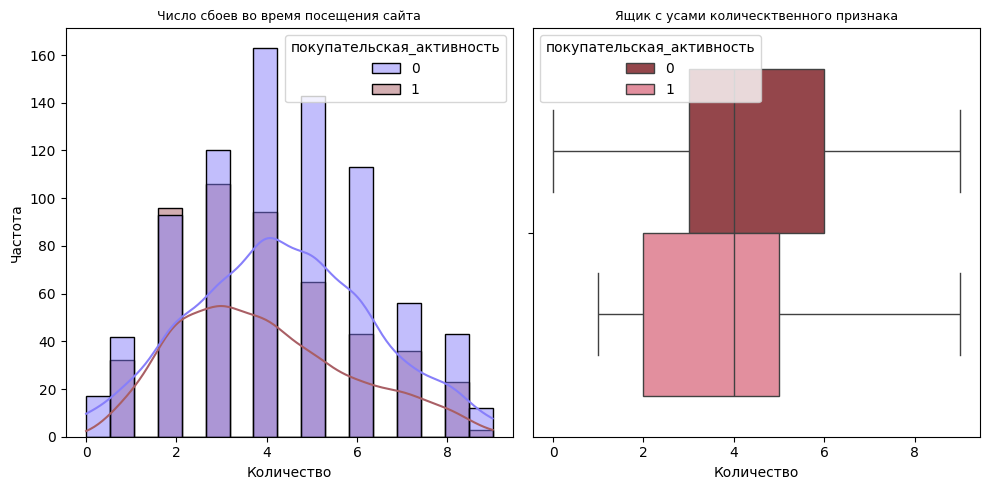

In [44]:
# ошибка_сервиса
hist_box_num_sub(
    market_file,
    'ошибка_сервиса',
    'Число сбоев во время посещения сайта',
    'Количество', 
    'Частота'
)

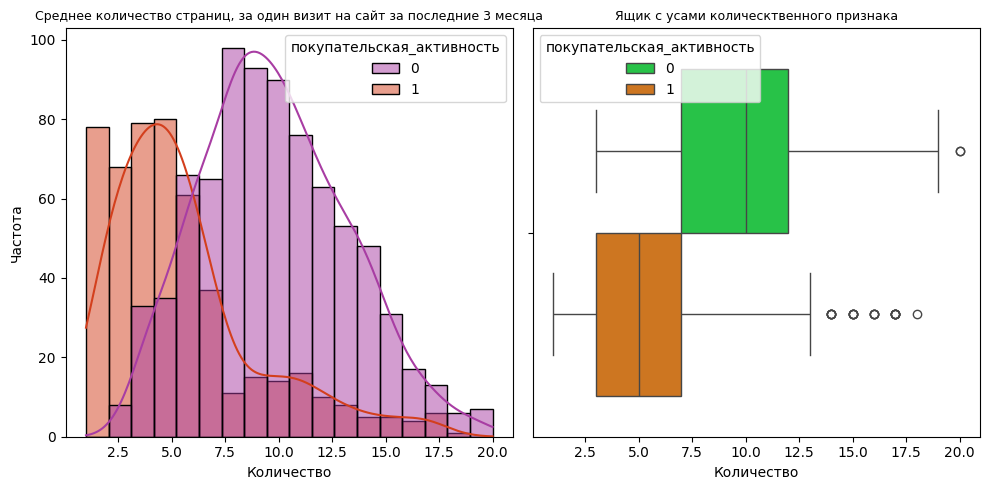

In [45]:
# страниц_за_визит
hist_box_num_sub(
    market_file,
    'страниц_за_визит',
    'Среднее количество страниц, за один визит на сайт за последние 3 месяца',
    'Количество', 
    'Частота'
)

Присутствуют выбросы у *Снизилать* от 12.6 и *Прежний уровень от 20*

In [46]:
# собственная функцция с генерацией случайного цвета
def hist_box_num_sub_no_cat(data, x, bins, title_hist, xlabel, ylabel, categ, hue):

    # создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # уникальные категории
    categories = categ.unique()

    # случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}
    colors_box = {cat: random_color() for cat in categories}

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # гистограмма
    sns.histplot(data=data, 
                 x=x, 
                 hue=hue,
                 bins=bins,
                 palette=colors_hist,
                 ax=axes[0], 
                 kde=True
                )
    axes[0].set_title(title_hist,  fontsize=9)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    
    # boxplot
    sns.boxplot(data=data, 
                x=x, 
                hue=hue,
                palette=colors_box,
                ax=axes[1]
               )
    axes[1].set_title('Ящик с усами колическтвенного признака',  fontsize=9)
    axes[1].set_xlabel(xlabel)
    axes[1].legend(title=hue, loc='upper left')

    plt.tight_layout()
    plt.show()

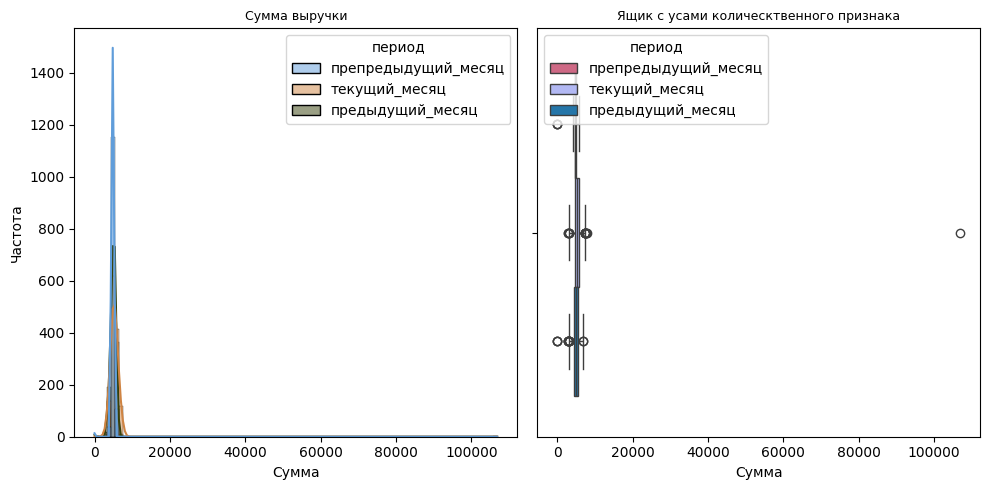

In [47]:
# выручка
hist_box_num_sub_no_cat(
    market_money,
    'выручка',
    100,
    'Cумма выручки',
    'Cумма', 
    'Частота',
    market_money.период,
    'период'
)

Присутствуют выбросы до 3450 и от 6450, так же есть аномалия.

In [48]:
market_money.выручка.describe() 

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

In [49]:
market_money.query('выручка >= 8000')

id         период   выручка
98  215380  текущий_месяц  106862.2

Отфильтруем данную аномалию после объединения таблиц

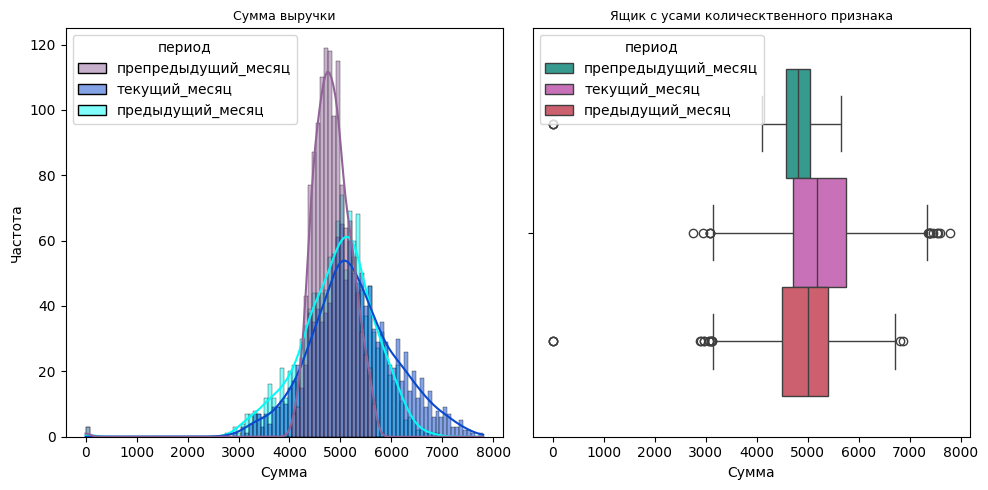

In [50]:
# выручка без аномалии
hist_box_num_sub_no_cat(
    market_money.query('выручка <= 8000'),
    'выручка',
    100,
    'Cумма выручки',
    'Cумма', 
    'Частота',
    market_money.период,
    'период'
)

Получается предыдущий месяц для компании в плане выручки был самый лучший.

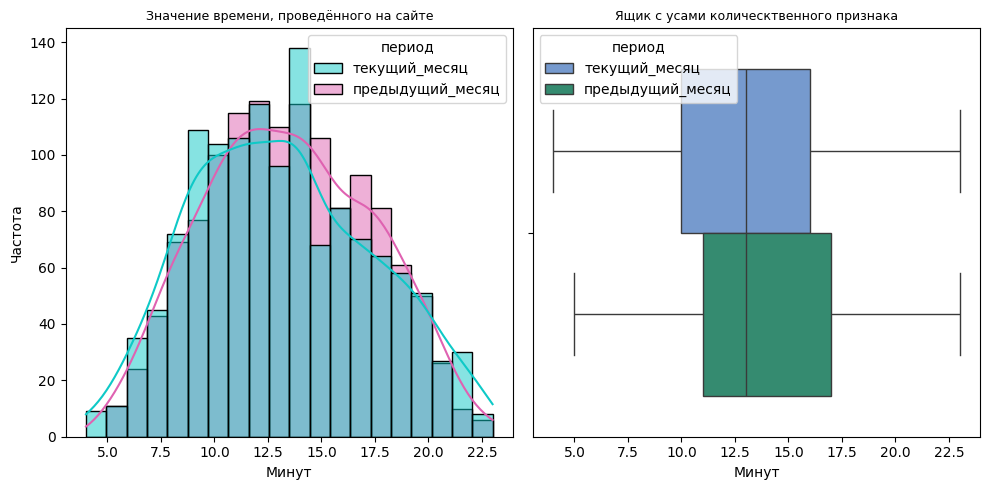

In [51]:
# минут
hist_box_num_sub_no_cat(
    market_time,
    'минут',
    20,
    'Значение времени, проведённого на сайте',
    'Минут', 
    'Частота',
    market_time.период,
    'период'
)

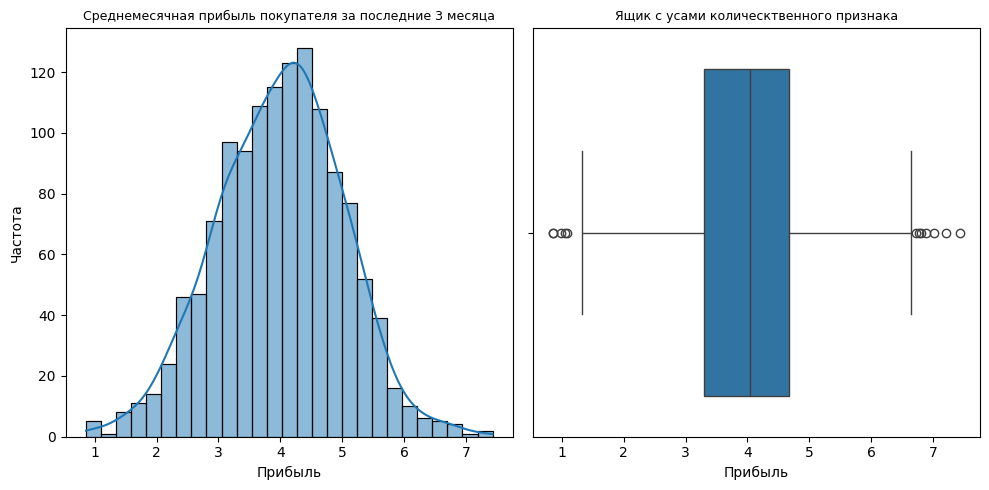

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
# гистограмма
sns.histplot(data=money, 
             x='прибыль',
             ax=axes[0], 
             kde=True
            )
axes[0].set_title('Среднемесячная прибыль покупателя за последние 3 месяца',  fontsize=9)
axes[0].set_xlabel('Прибыль')
axes[0].set_ylabel('Частота')
    
# boxplot
sns.boxplot(data=money, 
            x='прибыль',
            ax=axes[1]
            )
axes[1].set_title('Ящик с усами колическтвенного признака',  fontsize=9)
axes[1].set_xlabel('Прибыль')

plt.tight_layout()
plt.show()

Присутствуют выбросы до 1.4 и от 6.65

### Категориальные признаки

In [53]:
# собственная функцция
def barh_cat(data, title, xlabel, color):
    # гистограмма
    (data.value_counts()
     .sort_values(ascending=True)
     .plot(y='покупательская_активность', figsize=(6, 2),
           grid=True, kind='barh',
           color=color, edgecolor='darkblue')
          )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

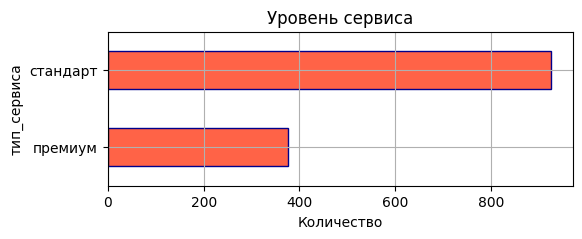

In [54]:
# тип_сервиса
barh_cat(market_file.тип_сервиса, 
         'Уровень сервиса', 
         'Количество', 
         'tomato')

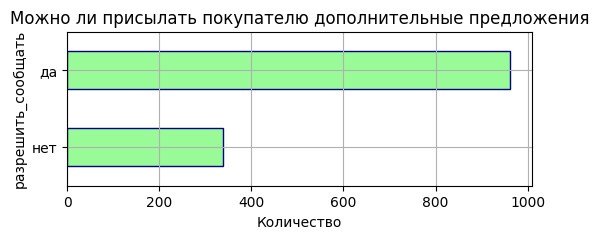

In [55]:
# разрешить_сообщать
barh_cat(market_file.разрешить_сообщать, 
         'Можно ли присылать покупателю дополнительные предложения', 
         'Количество', 
         'palegreen')

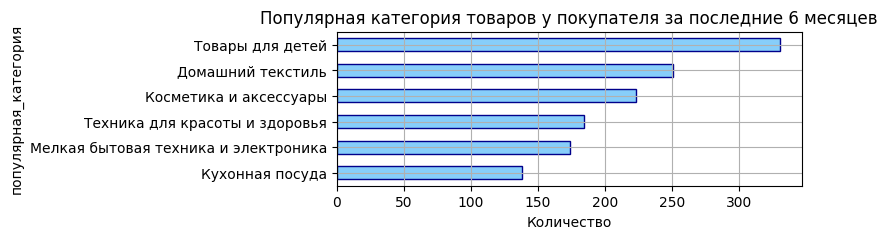

In [56]:
# популярная_категория
barh_cat(market_file.популярная_категория, 
         'Популярная категория товаров у покупателя за последние 6 месяцев', 
         'Количество', 
         'lightskyblue')

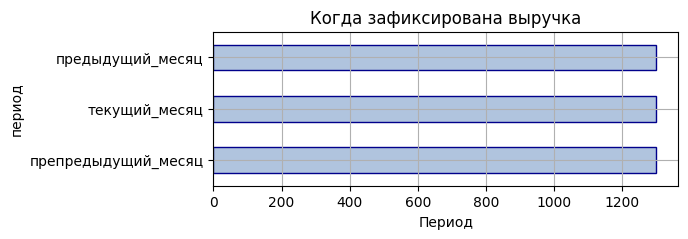

In [57]:
# период
barh_cat(market_money.период, 
         'Когда зафиксирована выручка', 
         'Период', 
         'lightsteelblue')

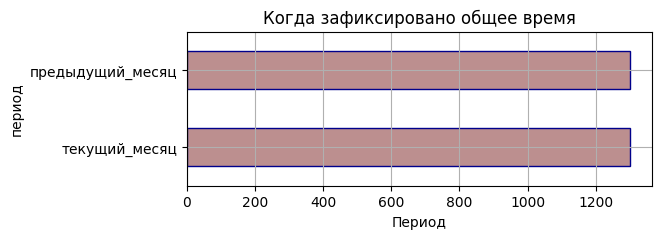

In [58]:
# период
barh_cat(market_time.период, 
         'Когда зафиксировано общее время', 
         'Период', 
         'rosybrown')

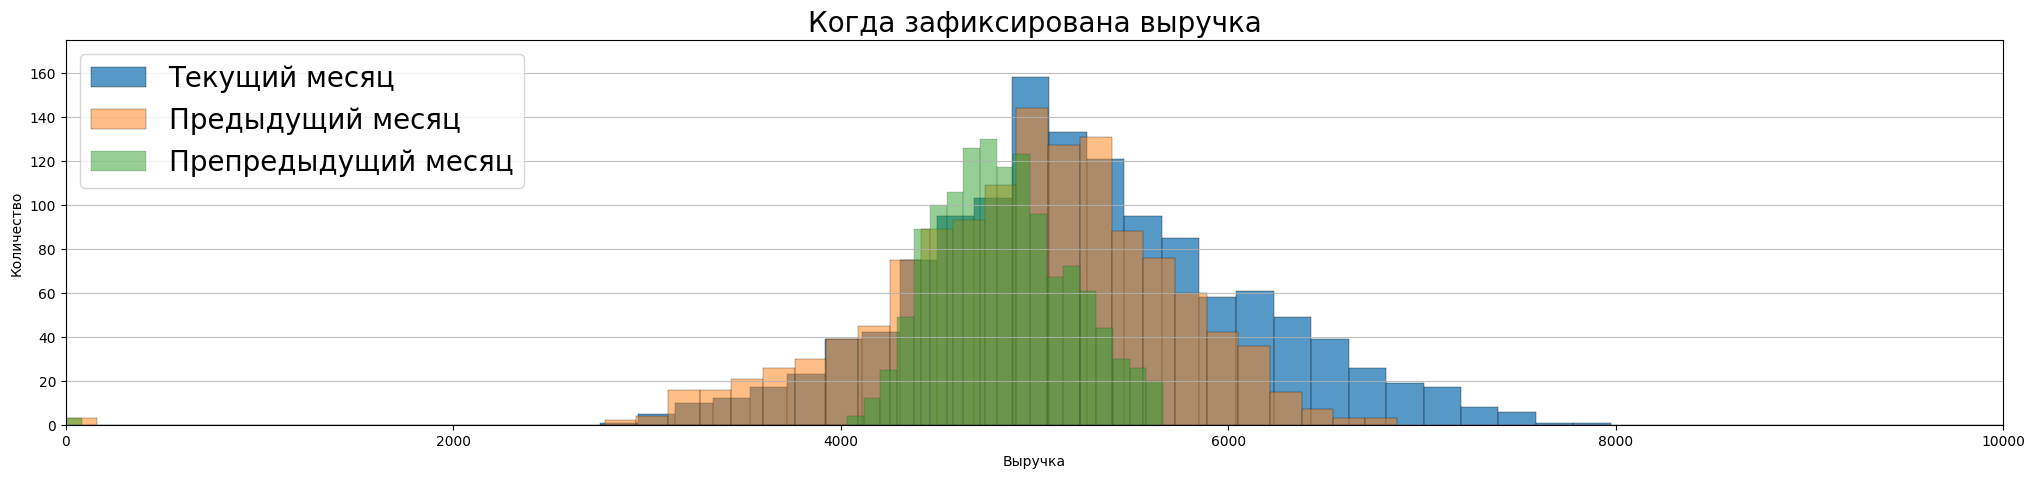

In [59]:
# сводный график
sns.histplot(market_money.query('период == "текущий_месяц"'), x='выручка')
sns.histplot(market_money.query('период == "предыдущий_месяц"'), x='выручка', alpha=.5)
sns.histplot(market_money.query('период == "препредыдущий_месяц"'), x='выручка', alpha=.5)
plt.legend(['Текущий месяц', 'Предыдущий месяц', 'Препредыдущий месяц'], loc='upper left', fontsize=20)
plt.ylim(0, 175)
plt.xlim(0, 10000)
plt.grid(axis='y', alpha=.8)
plt.title('Когда зафиксирована выручка', fontsize=20)
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.show()

Препредыдущий месяц мене прибыльный, текущий лучший по прибыли.

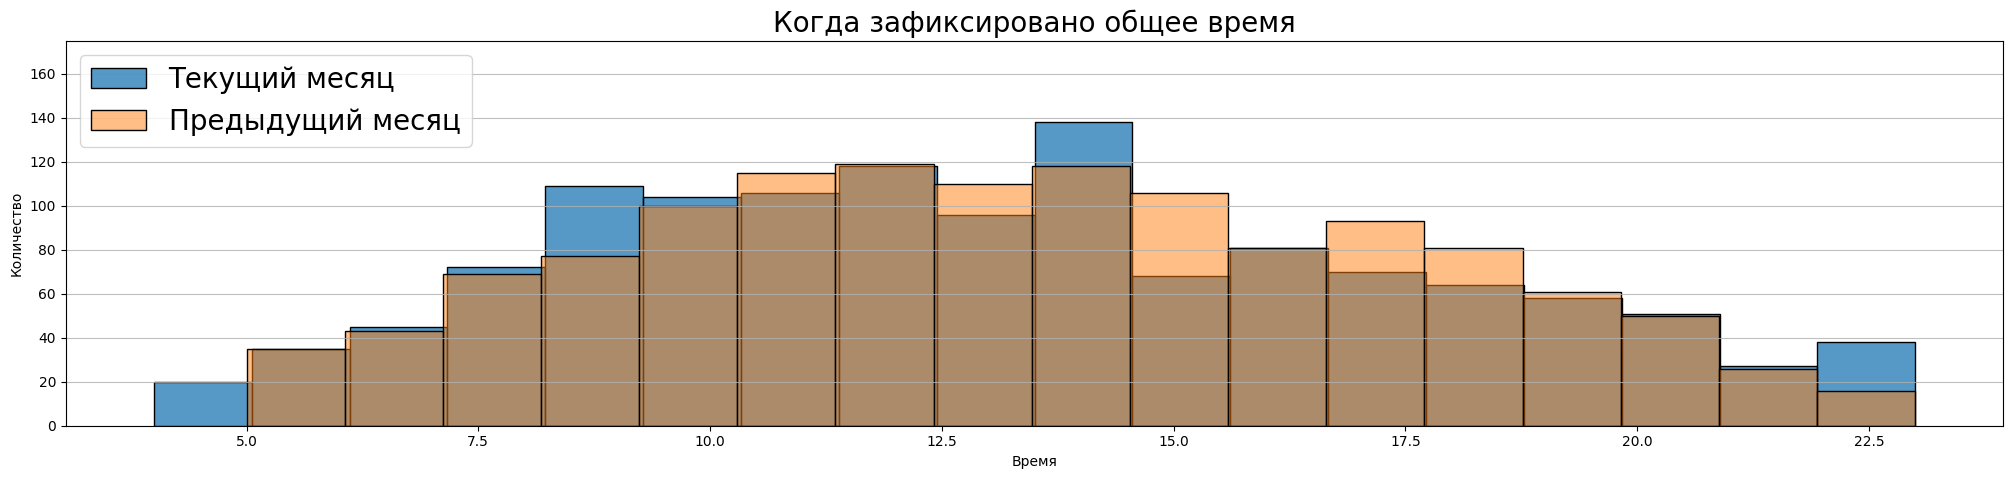

In [60]:
# сводные таблицы
sns.histplot(market_time.query('период == "текущий_месяц"'), x='минут')
sns.histplot(market_time.query('период == "предыдущий_месяц"'), x='минут', alpha=.5)
plt.legend(['Текущий месяц', 'Предыдущий месяц'], loc='upper left', fontsize=20)
plt.ylim(0, 175)
plt.grid(axis='y', alpha=.8)
plt.title('Когда зафиксировано общее время', fontsize=20)
plt.xlabel('Время')
plt.ylabel('Количество')
plt.show()

### Промежуточный вывод

После визуализации ясно следующее:

- есть выбросы в маркет_актив_6_мес у Снизилась до 1.75 от 6.5 и Прежний уровень до 1.6. У покупателей с сниженной активностью меньше коммуникаций с компанией.
- есть выбросы в маркет_актив_тек_мес у Прежний уровень до 3.1 от 4.9. По графикам заметно, что компания взаимодействовала в текущем месяце с клиентами с сниженной активность меньше, чем с клиентами с прежним уровнем. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего на каждого клиента.
- в длительность аналогично, клиенты с сниженной активностью не так давно зарегистрированы на сайте.
- есть выбросы в акционные_покупки у Прежний уровень от 0.41 Клиенты с сниженной активностью за последние 6 месяцев менше учавствовали в акцонных покупках. В районе единицы у группы снижена активность всплеск показателей, возможно была распродажа или большая акция на товары.
- есть выбросы в средний_просмотр_категорий_за_визит у Снизилась от 5. У этой же  категории меньше среднее просмотра.
- есть выбросы в неоплаченные_продукты_штук_квартал у Снизилась от 9 и Прежний уровень от 7. Логично, что у тех кто меньше покупает, меньше неоплаченных товаров.
- в ошибка_сервиса у Снизилась меньше сбоев. 
- есть выбросы в страниц_за_визит у Снизилась от 12.6 и Прежний уровень от 20. Аналогично, как везде, клиенты с сниженной активностью за один визит на сайт открывают меньше страниц.
- есть выбросы в выручка до 3450 и от 6450, так же есть аномалия. Получается предыдущий месяц для компании в плане выручки был самый лучший.
- есть выбросы в прибыль до 1.4 и от 6.65 Препредыдущий месяц мене прибыльный, текущий лучший по прибыли.

## Отбор клиентов с покупательской активностью

Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Для этого изучим кадры данных *money, market_money*, которые описывают какую прибыль получает магазин от продаж каждому покупателю за последние 3 месяца и сколько покупатель всего потратил за период взаимодействия с сайтом.

In [61]:
display(market_money.describe())

id        выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

In [62]:
market_money.query('выручка == 0')

id               период  выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

In [63]:
display(money.describe())

id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

Вывод: присутствует нулевое значение, это неактивные покупатели

## Сбор данных по группам клиентов

Создадим группы признаков на основе технического описания.

1. Коммуникация с клиентом, сюда войдут следующие признаки:
   - тип сервиса (тип_сервиса),
   - разрешение на сообщение (разрешить_сообщать),
   - маркетинг 6 месяцев (маркет_актив_6_мес),
   - маркетинг текущего месяца (маркет_актив_тек_мес),
   - длительность истории с клиентом (длительность).

2. Продуктовое поведение, сюда войдут следующие признаки:
   - наиболее частая котегория продукта в заказе (популярная_категория),
   - среднее число простматриваемых категорий продуктов за визит (средний_просмотр_категорий_за_визит),
   - число неоплаченных продуктов в корзине за последние 3 месяца (неоплаченные_продукты_штук_квартал).
  
3. Финансовое поведение, сюда войдут следующие признаки:
   - разница в выручке предыдущего и препредыдущего месяцев (предыдущий_месяц - препредыдущий_месяц),
   - разница в выручке текущего и предыдущего месяцев (текущий_месяц - предыдущий_месяц),
   - выручка в текущем месяце (текущий_месяц).

4. Поведение на сайте, сюда войдут следующие признаки:
   - время на сайте за прошлый год (предыдцщий_месяц + текущий_месяц),
   - время на сайте за предыдущий месяц (предыдцщий_месяц),
   - время на сайте за теукщий месяц (текущий_месяц),
   - минут за визит (минут),
   - число страниц за визит (страниц_за_визит),
   - сбой сайта(ошибка_сервиса).

# Объединение таблиц

Объединим таблицы market_file.csv, market_money.csv, market_time.csv

In [64]:
# сводные таблицы
market_time_pivot = (market_time
                     .pivot_table(index = ['id'],
                                  columns = ['период'])
                     .reset_index()
                     .set_index('id')
                    )
market_time_pivot.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']

market_money_pivot = (market_money
                .pivot_table(index = ['id'],
                             columns = ['период']
                            )
                .reset_index()
                .set_index('id')
               )
market_money_pivot.columns = ['выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 
                              'выручка_текущий_месяц']

market_money_time = (market_time_pivot.merge(market_money_pivot, 
                                             how='left', 
                                             on=['id']
                                            ))

In [65]:
# добавим в таблицу market_file
market_full = (market_file.merge(market_money_time, how='left', on='id'))

# добавим в столбцы всего_минут и общая_выручка
(market_full
 .insert(15, 'всего_минут', 
         (market_full['минут_предыдущий_месяц'] + 
          market_full['минут_текущий_месяц'])
        )
)
(market_full
 .insert(19, 'общая_выручка',
         (market_full['выручка_препредыдущий_месяц'] + 
          market_full['выручка_предыдущий_месяц'] + 
          market_full['выручка_текущий_месяц'])
        )
)

Фильтруем наиболее значимые для исследования отклонения

In [66]:
market_full = market_full.query('выручка_препредыдущий_месяц > 0 and выручка_текущий_месяц < 8000')

# Корреляционный анализ

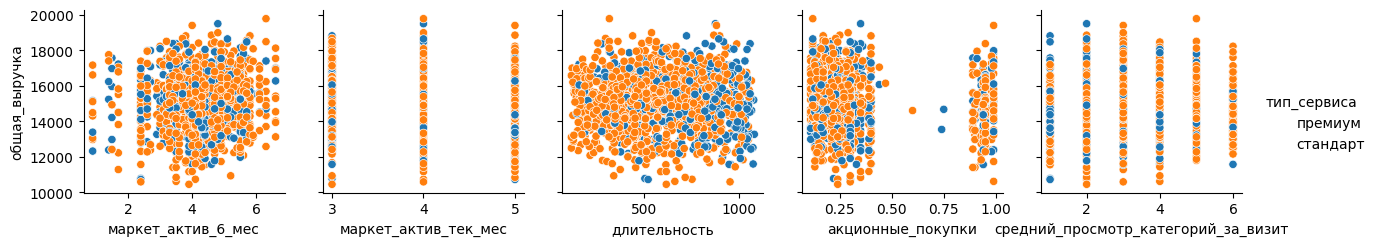

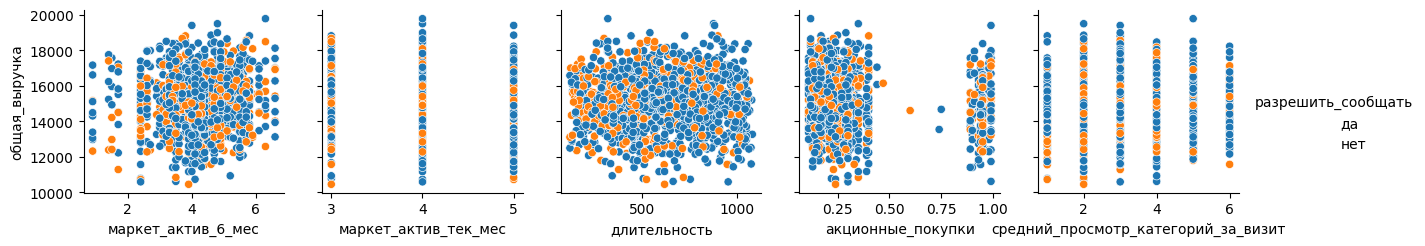

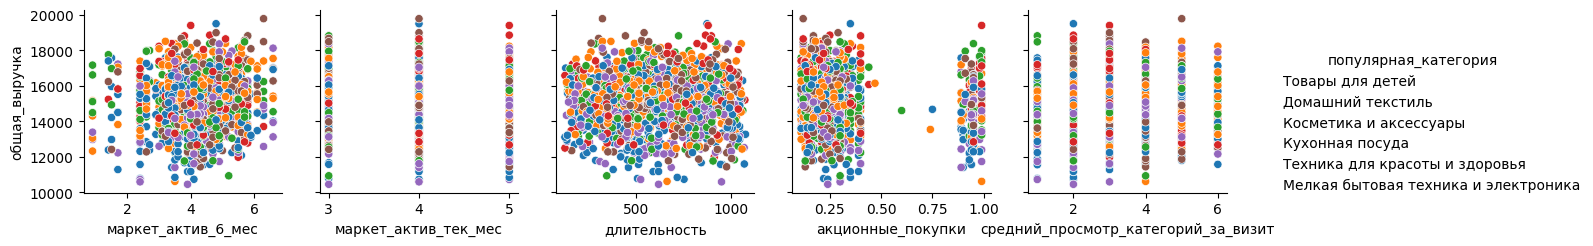

In [67]:
targ = 'общая_выручка'
factor_1 = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
            'акционные_покупки', 'средний_просмотр_категорий_за_визит']
cat = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for category in cat:
    g = sns.PairGrid(market_full, hue = category, x_vars=factor_1, y_vars=targ)
    g.add_legend()
    g.map(sns.scatterplot)

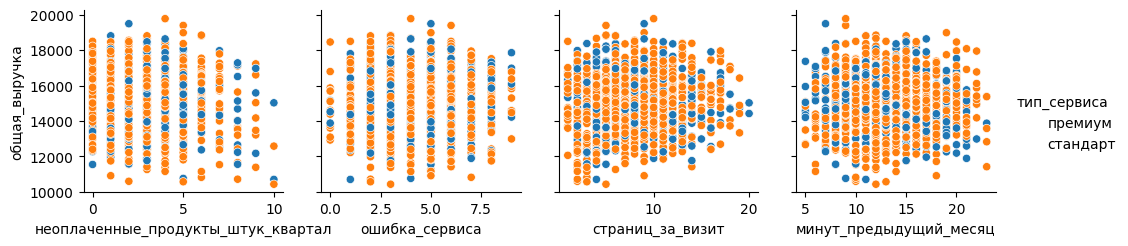

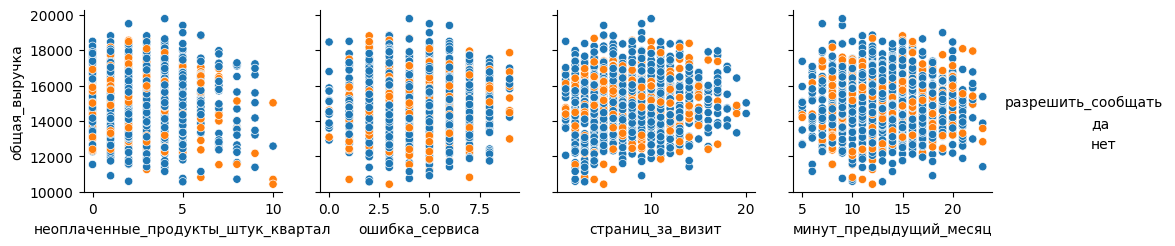

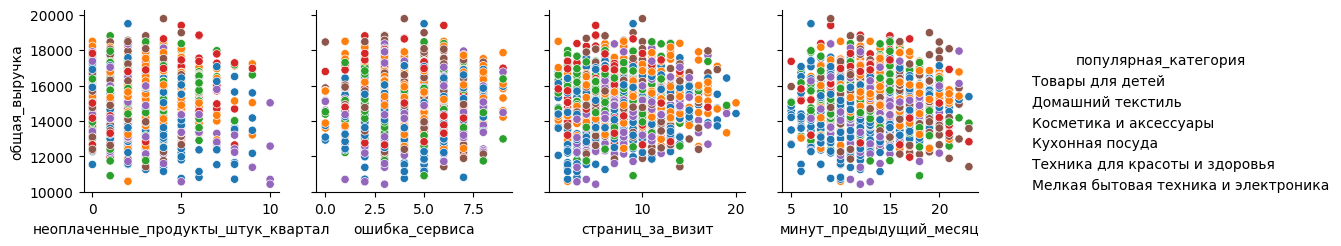

In [68]:
factor_2 = ['неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
            'страниц_за_визит', 'минут_предыдущий_месяц']
for category in cat:
    g = sns.PairGrid(market_full, hue = category, x_vars=factor_2, y_vars=targ)
    g.add_legend()
    g.map(sns.scatterplot)

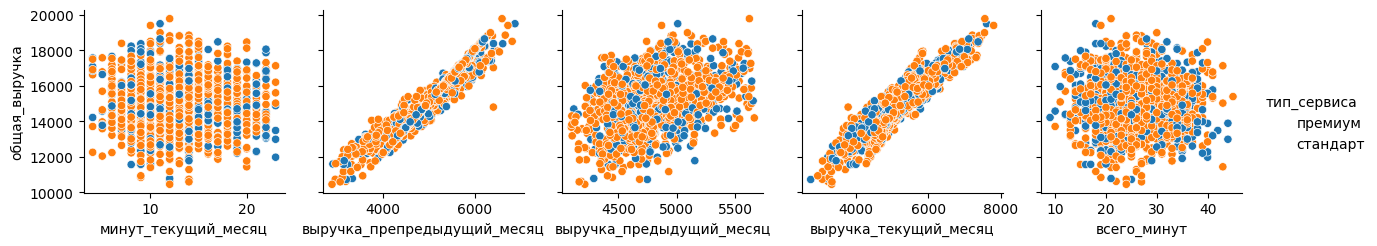

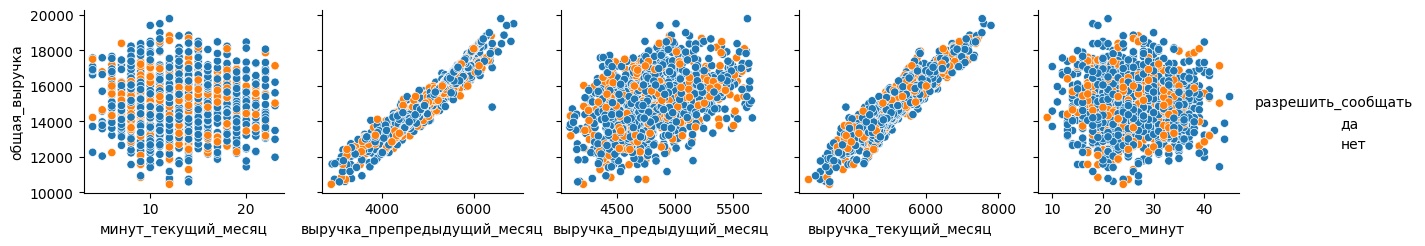

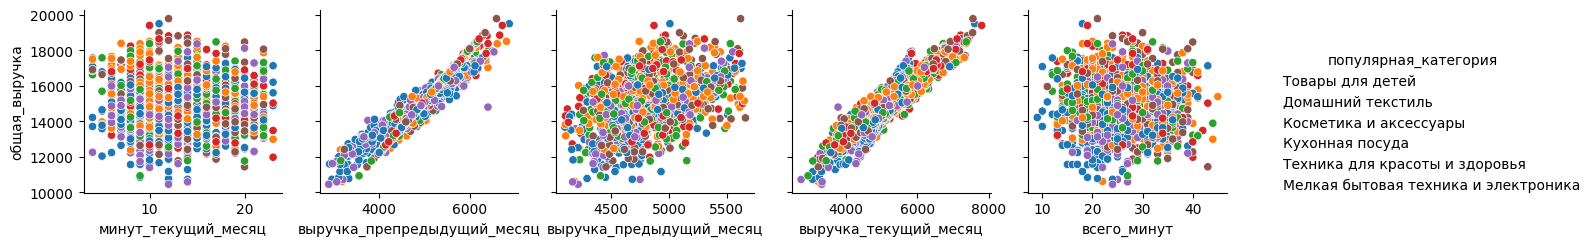

In [69]:
factor_3 = ['минут_текущий_месяц', 'выручка_препредыдущий_месяц', 
            'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
            'всего_минут']
for category in cat:
    g = sns.PairGrid(market_full, hue = category, x_vars=factor_3, y_vars=targ)
    g.add_legend()
    g.map(sns.scatterplot)

После построение диаграммы рассеяния количественных признаков можно сделать следующие выводы:

- в основном имею хорошую дисперсию;
- в **акционные_покупки** образовалось 2 кластера по отношению к категории **разрешить_сообщать**, до 0.38 и от 0.85;
- то же самое наблюдаем в **акционные_покупки** по отношению к категории **популярная_категория**, до 0.38 и от 0.85.

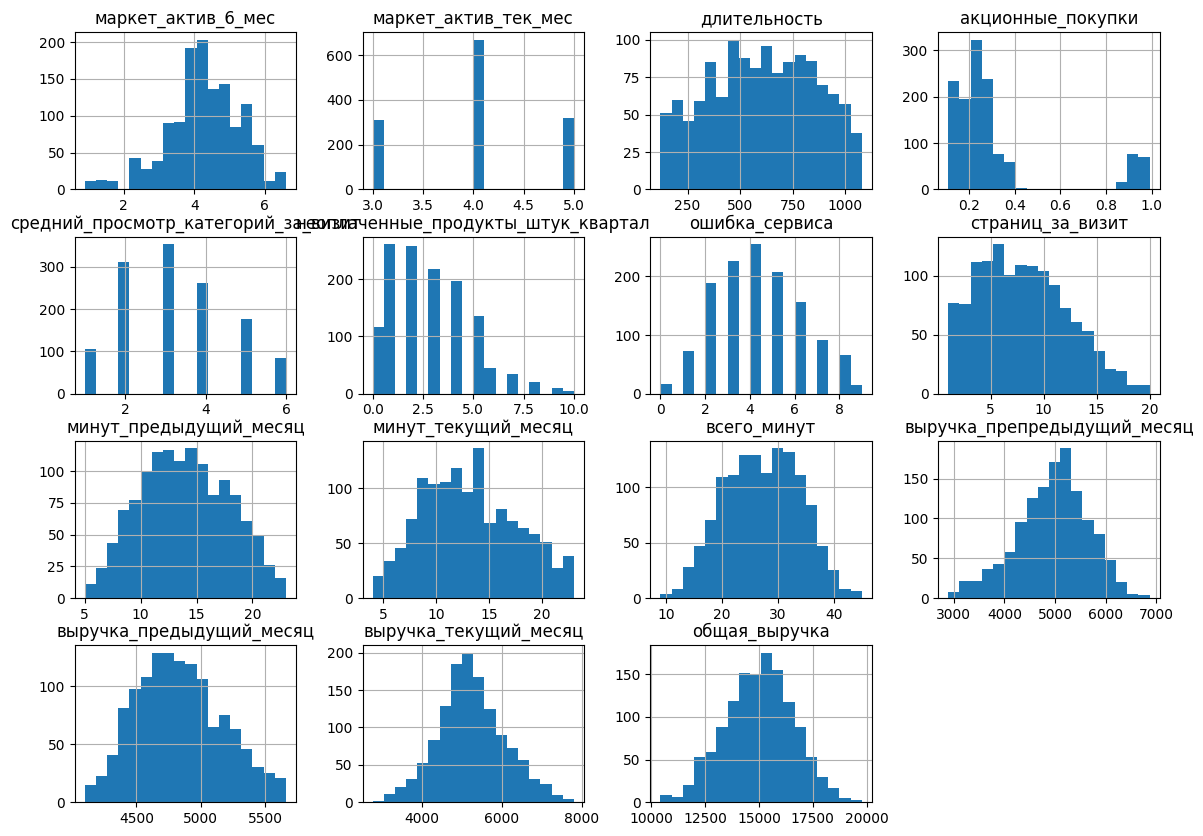

In [70]:
# распределение количественных признаков
(
    market_full[
    market_full.
    select_dtypes(include='number')
    .columns.tolist()
    ]
    .drop(['id', 'покупательская_активность'],
          axis=1)
    .hist(bins=18, figsize=(14, 10))
    )
plt.show()

Судя по прафикам распределения количественных признаков можно сделать следующие выводы:

- в основном количественные признаки имеют нормальное распределение;
- присутствуют отклонения от нормальности у **акционные_покупки, неоплаченные_продукты_штук_квартал, страниц_за_визит**;
- значит оценим корреляцию целевого признака с вхордящими с помощью библиотеки phik, потому что целевой категориальный.

## Общая корреляция

In [71]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['длительность', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
                'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

# считаем корреляцию
phik_overview = phik_matrix(
    market_full.drop(
        ['id', 'всего_минут', 'общая_выручка'],
        axis=1
    ),
    interval_cols=interval_cols) 

# размер матрицы
phik_overview.shape

(17, 17)

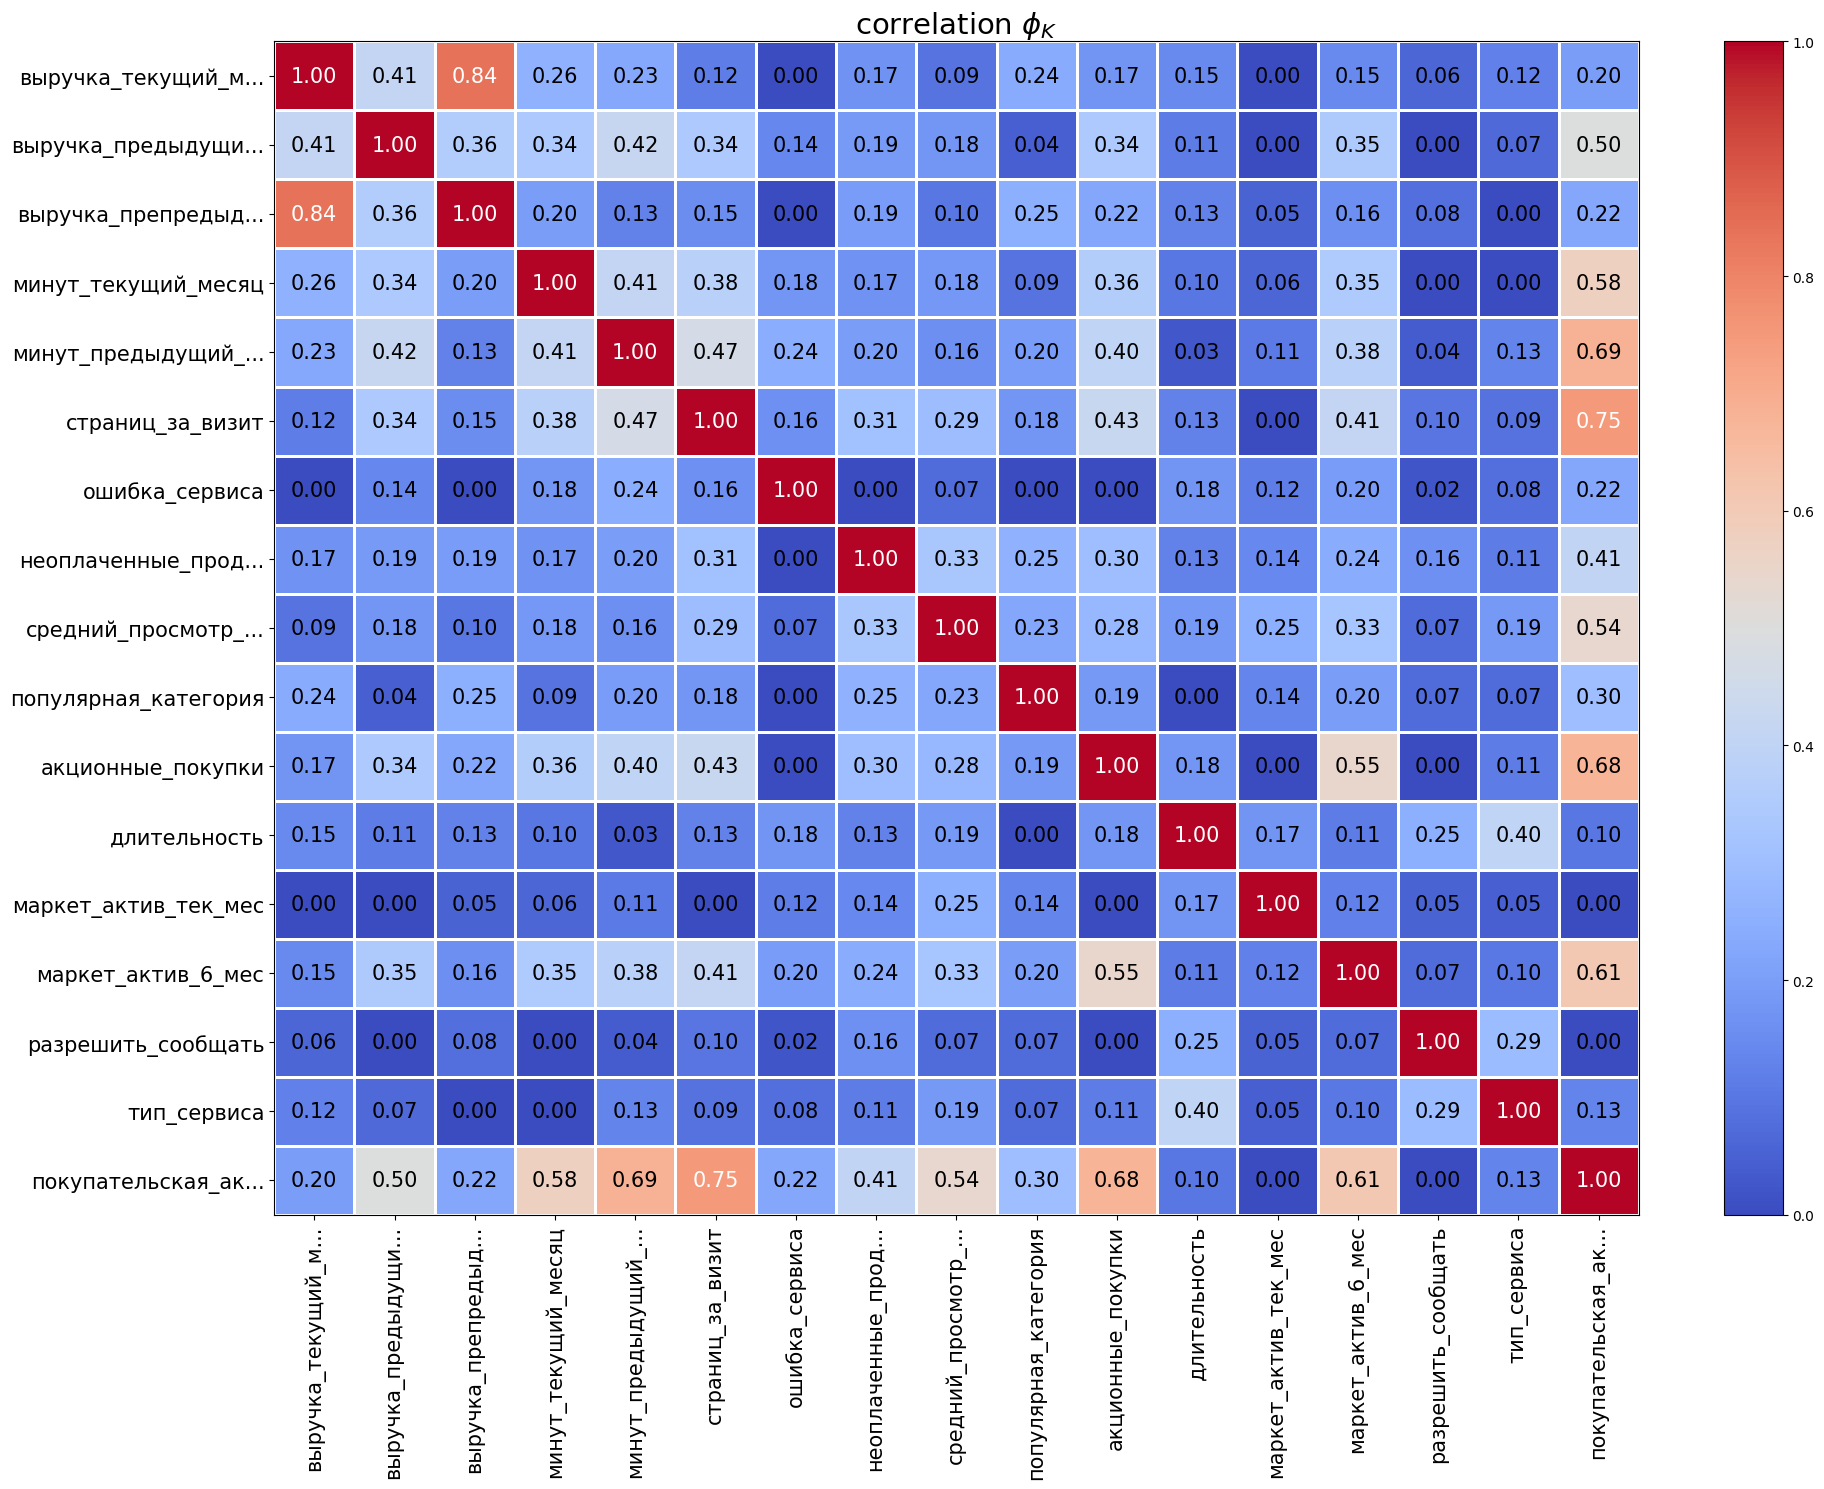

In [72]:
# визуализация
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:

- теплые тона говорят о сильной линейной зависимости, а холодные — о слабой;
- корреляция между целевым и остальными достаточно слабая, кроме **минут_предыдущий_месяц, страниц_за_визит, акционные_покупки**;
- мультиколлинеарность отсутствует, так как порог для подтверждения 0.9-0.95;
- утечки целевого признака через входящие не наблюдается.

## Раздельная корреляция

In [73]:
# считаем корреляцию без сниженной активности
phik_overview_norm = phik_matrix(
    market_full
    .query('покупательская_активность == 0')
    .drop(['id', 'покупательская_активность', 'всего_минут', 'общая_выручка'], axis=1),
    interval_cols=interval_cols
) 

# размер матрицы
phik_overview_norm.shape

(16, 16)

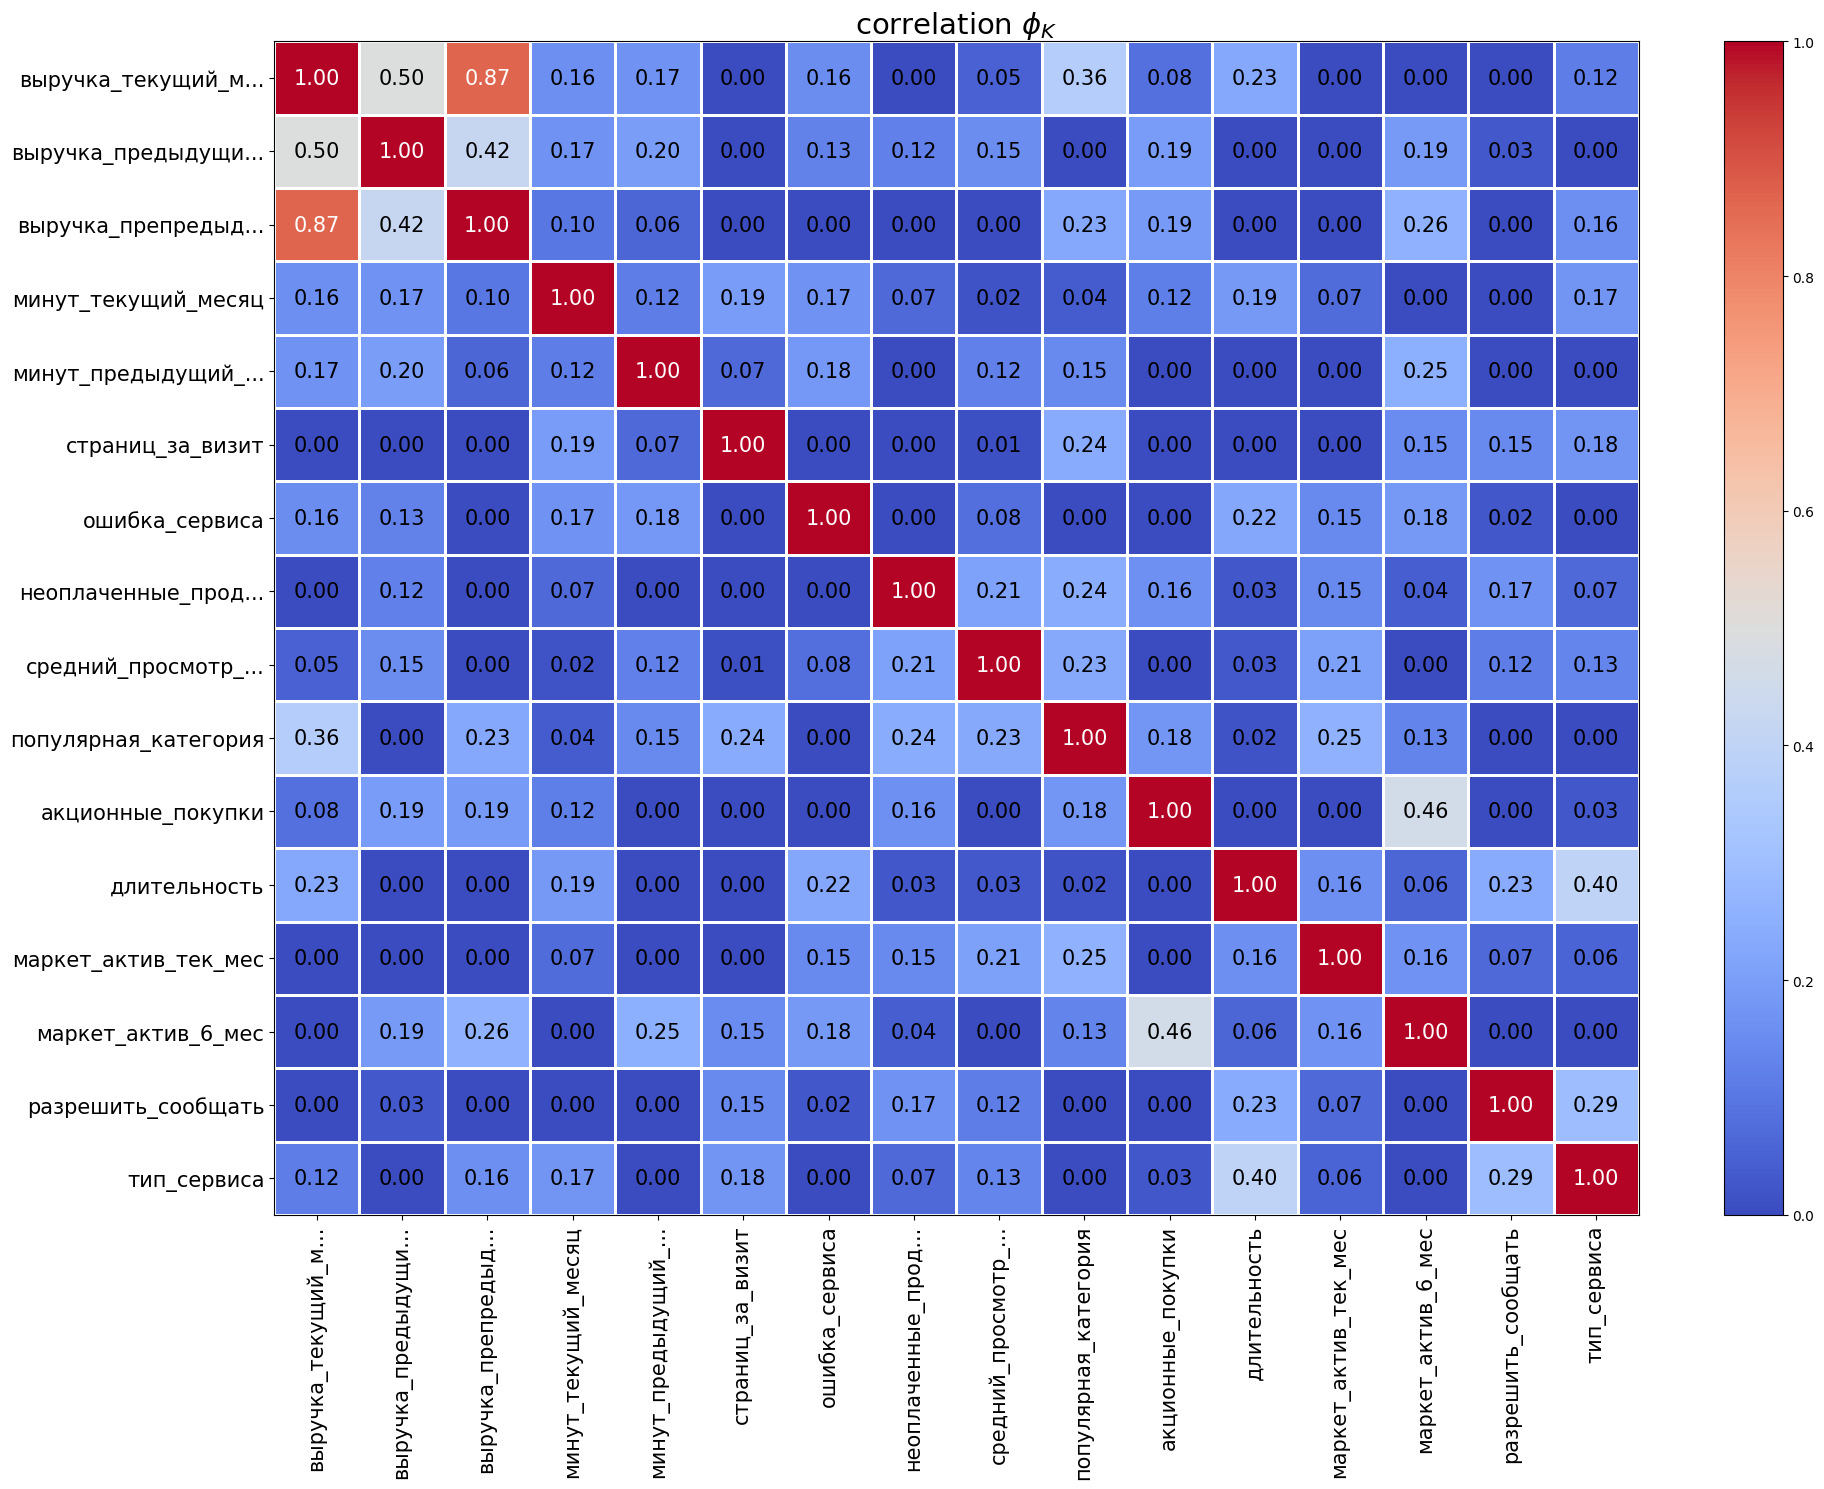

In [74]:
# визуализация
plot_correlation_matrix(
    phik_overview_norm.values,
    x_labels=phik_overview_norm.columns,
    y_labels=phik_overview_norm.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [75]:
# считаем корреляцию с сниженной активностью
phik_overview_down = phik_matrix(
    market_full
    .query('покупательская_активность == 1')
    .drop(['id', 'покупательская_активность', 'всего_минут', 'общая_выручка'], axis=1),
    interval_cols=interval_cols
) 

# размер матрицы
phik_overview_down.shape

(16, 16)

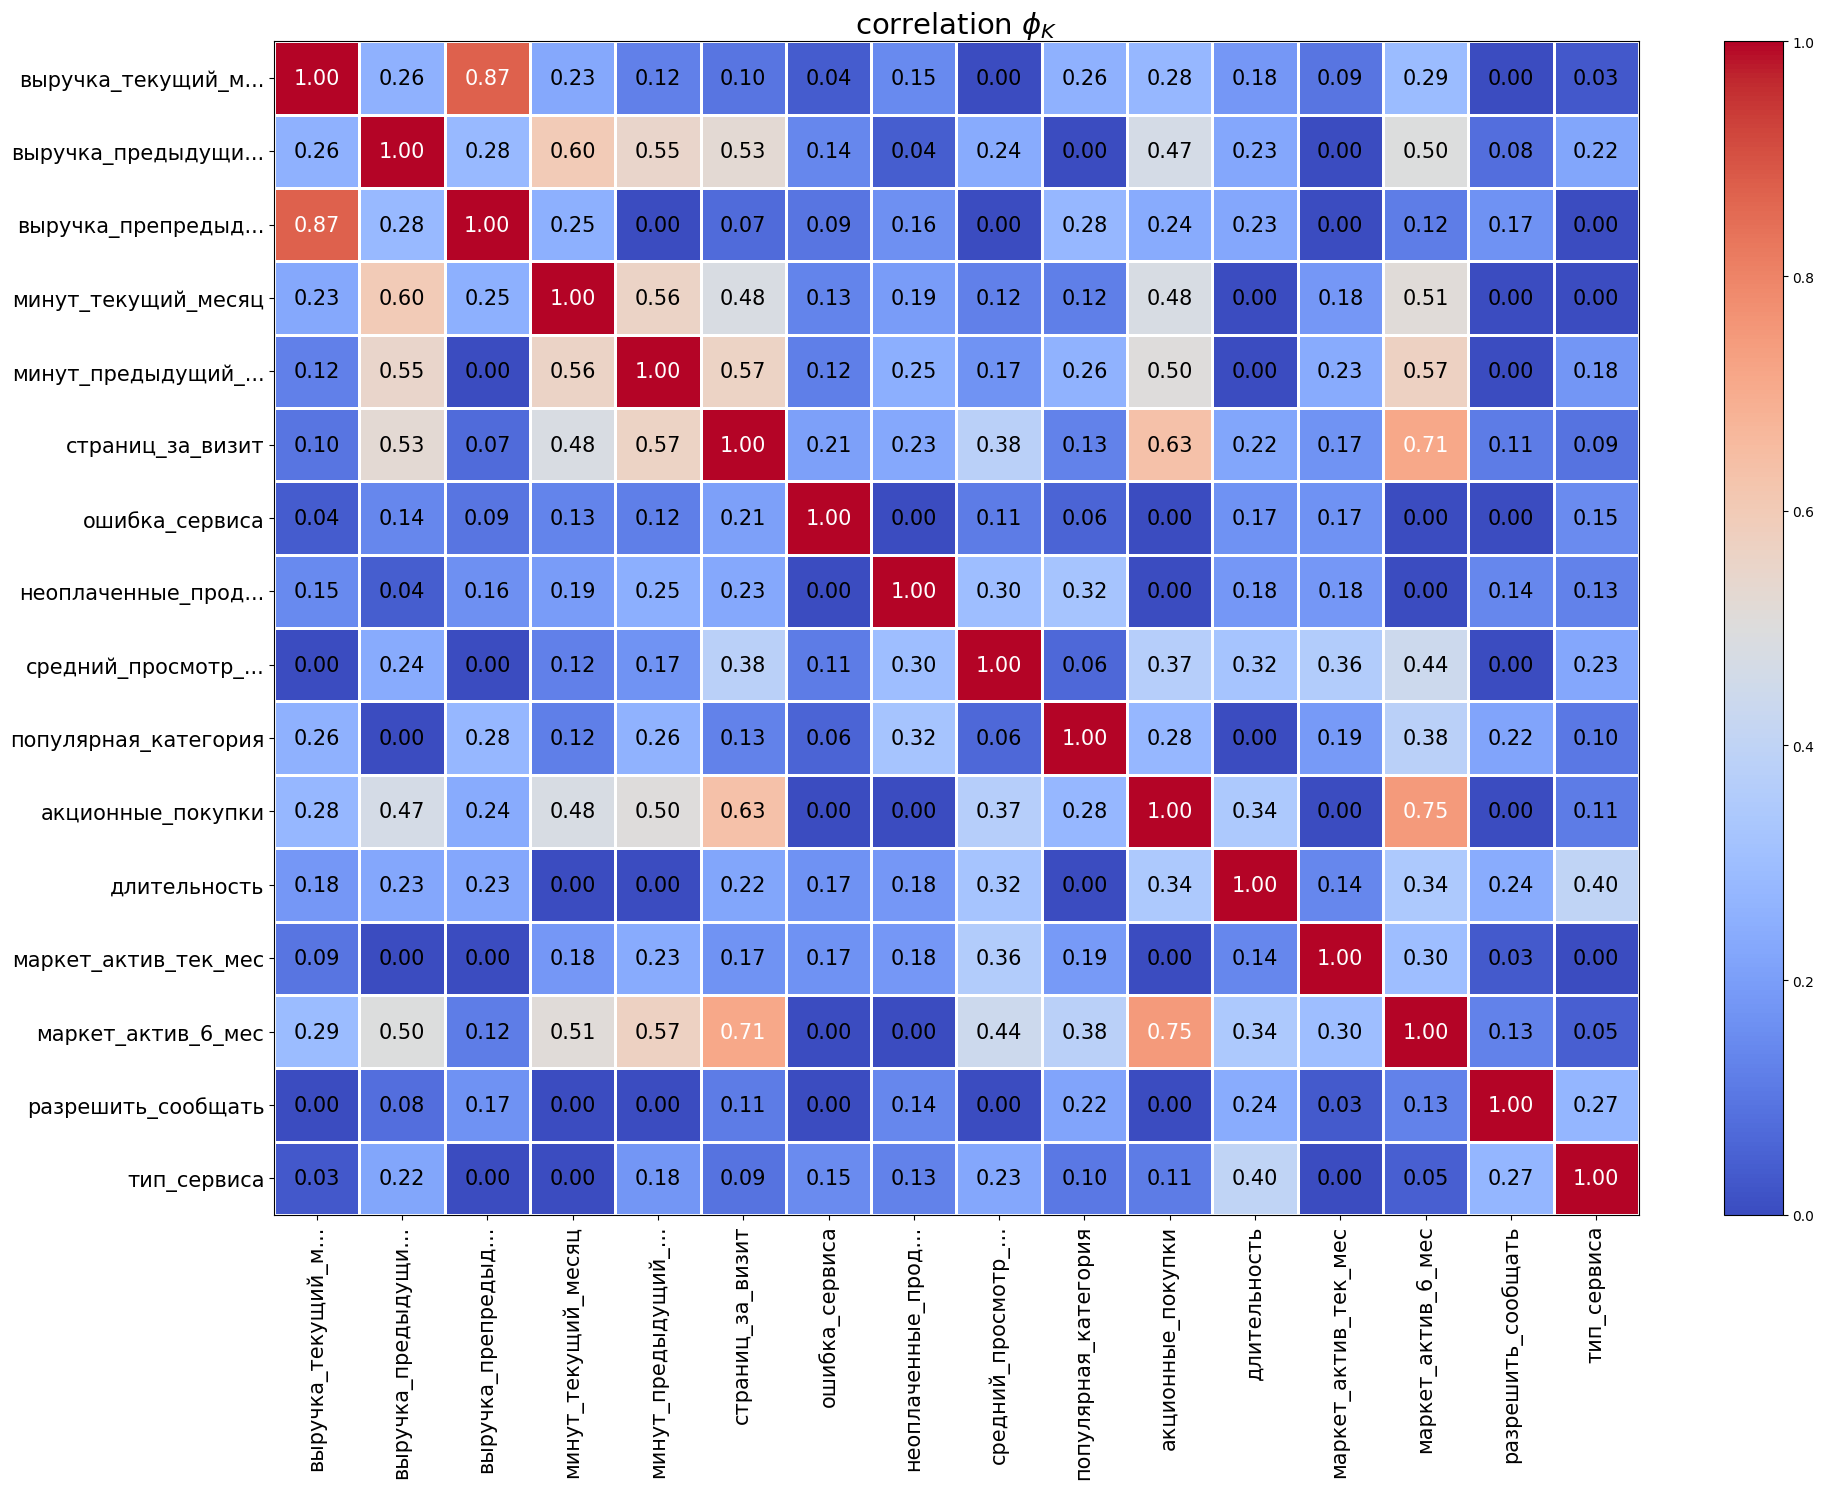

In [76]:
# визуализация
plot_correlation_matrix(
    phik_overview_down.values,
    x_labels=phik_overview_down.columns,
    y_labels=phik_overview_down.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

## Промежуточный вывод

После построение диаграммы рассеяния количественных признаков можно сделать следующие выводы:

- в основном имею хорошую дисперсию;
- в **акционные_покупки** образовалось 2 кластера по отношению к категории **разрешить_сообщать**, до 0.38 и от 0.85;
- то же самое наблюдаем в **акционные_покупки** по отношению к категории **популярная_категория**, до 0.38 и от 0.85.

Судя по прафикам распределения количественных признаков можно сделать следующие выводы:

- в основном количественные признаки имеют нормальное распределение;
- присутствуют отклонения от нормальности у **акционные_покупки, неоплаченные_продукты_штук_квартал, страниц_за_визит**;
- значит оценим корреляцию целевого признака с вхордящими с помощью библиотеки phik, потому что целевой категориальный.

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:

- теплые тона говорят о сильной линейной зависимости, а холодные — о слабой;
- корреляция между целевым и остальными достаточно слабая, кроме **минут_предыдущий_месяц, страниц_за_визит, акционные_покупки**;
- мультиколлинеарность отсутствует, так как порог для подтверждения 0.9-0.95;
- утечки целевого признака через входящие не наблюдается.

После построение корреляционной матрицы входящих признаков без целевого можно сделать следующие выводы:
- выделяется пара **выручка_текущий_месяц и выручка_препредыдущий_месяц**, они находятся в одном группе признаков *Финансовое поведение*;
- мультиколлинеарность отсутствует.

# Использование пайплайнов

## Подготовка данных

Используем `ColumnTransformer`, количественные и категориальные признаки обработаем в пайплайне раздельно.

Список признаков, учавствующих в моделировании

Входные количественные:
- маркет_актив_6_мес,
- маркет_актив_тек_мес,
- акционные_покупки,
- средний_просмотр_категорий_за_визит,
- неоплаченные_продукты_штук_квартал,
- ошибка_сервиса,
- минут_предыдущий_месяц,
- минут_текущий_месяц,
- выручка_препредыдущий_месяц,
- выручка_предыдущий_месяц,
- выручка_текущий_месяц,

Входные категориальные:
- тип_сервиса,
- разрешить_сообщать,
- популярная_категория,
- *категория_длительности,
- *категория_визитов.

In [77]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# загружаем данные
X_train, X_test, y_train, y_test = train_test_split(
    market_full.drop(
        ['id', 'покупательская_активность', 'всего_минут', 'общая_выручка'],
        axis=1
    ),
    market_full['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_full['покупательская_активность']
)

# создаём списки с названиями признаков
ohe_columns = [
    'разрешить_сообщать',
    'тип_сервиса',
    'популярная_категория'
]

num_columns = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
    'минут_предыдущий_месяц', 'минут_текущий_месяц', 
    'выручка_препредыдущий_месяц',	'выручка_предыдущий_месяц',	
    'выручка_текущий_месяц'
]

# создаём пайплайн для подготовки признаков из списка ohe_columns - заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe_before', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),

        # заполним пропуски, которые появляются после Ordinal-кодирования.
        (
            'simpleImputer_ohe_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка num_columns - SimpleImputer + MinMaxScaler
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num_before', 
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        
        # проводим MinMaxScaler-нормализацию с помощью MinMaxScaler, назовём этот шаг `num`
        (
            'num', 
            MinMaxScaler()
        ),
        
        ('simpleImputer_num_after', 
         SimpleImputer(missing_values=np.nan, strategy='mean')),
    ]
    )

# код для пайплайна подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        
        # используем смесь андерсэмплинга с оверсэмплингом SMOTETomek
        ('models', SMOTETomek(random_state=RANDOM_STATE))
    ]
)

## Обучим модели

`KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression()`.

In [79]:
market_full.покупательская_активность.value_counts(normalize=True)

покупательская_активность
0    0.618827
1    0.381173
Name: proportion, dtype: float64

На лицо явный дисбаланс, мажорный класс — *Прежний уровень*, представленный значительно бóльшим числом наблюдений по сравнению 
с остальным, для оценки моделей используем метрику ROC-AUC, так как она не чувствительна к дисбалансу классов. 

## Лучшая модель

### Randomized_searchCV

In [80]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 10),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            max_iter=300
        )],
        'models__C': range(5, 15, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [81]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

# лучшая модель
display('Лучшая модель', randomized_search.best_estimator_)
display('Параметры', randomized_search.best_params_)
display('Метрика roc_auc', randomized_search.best_score_)

'Лучшая модель'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_ohe_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['разрешить_сообщать...
                                                   'маркет_актив_тек_мес',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'минут_предыдущий_месяц',
                                                   'минут_текущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_текущий_месяц'])])),
                ('models',
                 LogisticRegression(C=10, max_iter=300, penalty='l1',
                                    random_state=42, solver='liblinear'))])

'Параметры'

{'preprocessor__num': RobustScaler(),
 'models__C': 10,
 'models': LogisticRegression(max_iter=300, penalty='l1', random_state=42,
                    solver='liblinear')}

'Метрика roc_auc'

0.8950780623661683

In [82]:
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

rank_test_score                                       param_models  \
2                1  LogisticRegression(max_iter=300, penalty='l1',...   
3                2  LogisticRegression(max_iter=300, penalty='l1',...   
1                3  LogisticRegression(max_iter=300, penalty='l1',...   
8                4                             KNeighborsClassifier()   
5                5                             KNeighborsClassifier()   
9                6                             KNeighborsClassifier()   
6                7                             KNeighborsClassifier()   
0                8                             KNeighborsClassifier()   
4                9                             KNeighborsClassifier()   
7               10                             KNeighborsClassifier()   

   mean_test_score                                             params  
2         0.895078  {'preprocessor__num': RobustScaler(), 'models_...  
3         0.894827  {'preprocessor__num': 'passthrough', 'models__...  
1         0.894811  {'preprocessor__num': StandardScaler(), 'model...  
8         0.764961  {'preprocessor__num': 'passthrough', 'models__...  
5         0.760884  {'preprocessor__num': 'passthrough', 'models__...  
9         0.750069  {'preprocessor__num': 'passthrough', 'models__...  
6         0.723367  {'preprocessor__num': RobustScaler(), 'models_...  
0         0.706294  {'preprocessor__num': MinMaxScaler(), 'models_...  
4         0.700693  {'preprocessor__num': MinMaxScaler(), 'models_...  
7         0.698559  {'preprocessor__num': MinMaxScaler(), 'models_...

По итогу лучшая модель `LogisticRegression`, с параметрами `solver='liblinear', max_iter=300` и скайлер `StandardScaler`

## Тестирование лучшей модели на основе `RandomizedSearchSV`

In [83]:
# обучим лучшую модель SVC
best_model_rs = randomized_search.best_estimator_

# применение трансформации на обучающей и тестовой выборках
X_train_transform = best_model_rs.named_steps['preprocessor'].transform(X_train)
X_test_transform = best_model_rs.named_steps['preprocessor'].transform(X_test)

# создадим тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из шага пайплайна 
X_train_df = pd.DataFrame(
    X_train_transform,
    columns=best_model_rs.named_steps['preprocessor'].get_feature_names_out()
)
X_test_df = pd.DataFrame(
    X_test_transform,
    columns=best_model_rs.named_steps['preprocessor'].get_feature_names_out()    
)

best_model = best_model_rs.named_steps['models'].fit(X_train_df, y_train)

# рассчитаем ROC-AUC на тестовых данных
y_pred_proba = best_model.predict_proba(X_test_df)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC = ', roc_auc.round(2))

ROC-AUC =  0.92


По итогу подготовки данных модель LogisticRegression имеет показатель метрики качества классификации `ROC-AUC = 0.92`

# Анализ важности признаков

Чтобы оценить важность признаков используем модель `LogisticRegression`, так как она лучшая по итогу `RandomizedSearchCV`.

## Важность признаков для лучшей модели и график важности с помощью метода SHAP. 

### Диаграмма `shap.plots.beeswarm`

Полезный инструмент, позволяющий визуализировать все SHAP‑значения для каждого признака. По оси x этой диаграммы SHAP‑значения сгруппированы по признакам. А цвет точек указывает на соответствующее значение признака. Обычно точки, цвет которых ближе к красному, указывают на более высокие значения признаков. Может помочь в выявлении важных взаимоотношений между признаками и прогнозами модели. На нашей диаграмме признаки упорядочены по их средним SHAP‑значениям. Вот как читать этот график:

- Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0 (прежний уровень активности), 
а положительные справа — к классу 1 (активность снизилась).
- Чем толще линия по вертикали, тем больше наблюдений сгруппированы вместе: у них близкие значения Шепли. Это значит, что модель уверенно присваивает SHAP-значения, с учётом закономерностей в данных.
- Цвет точки отражает значения каждого признака объекта: чем краснее объект, тем больше признак, указанный на оси Y

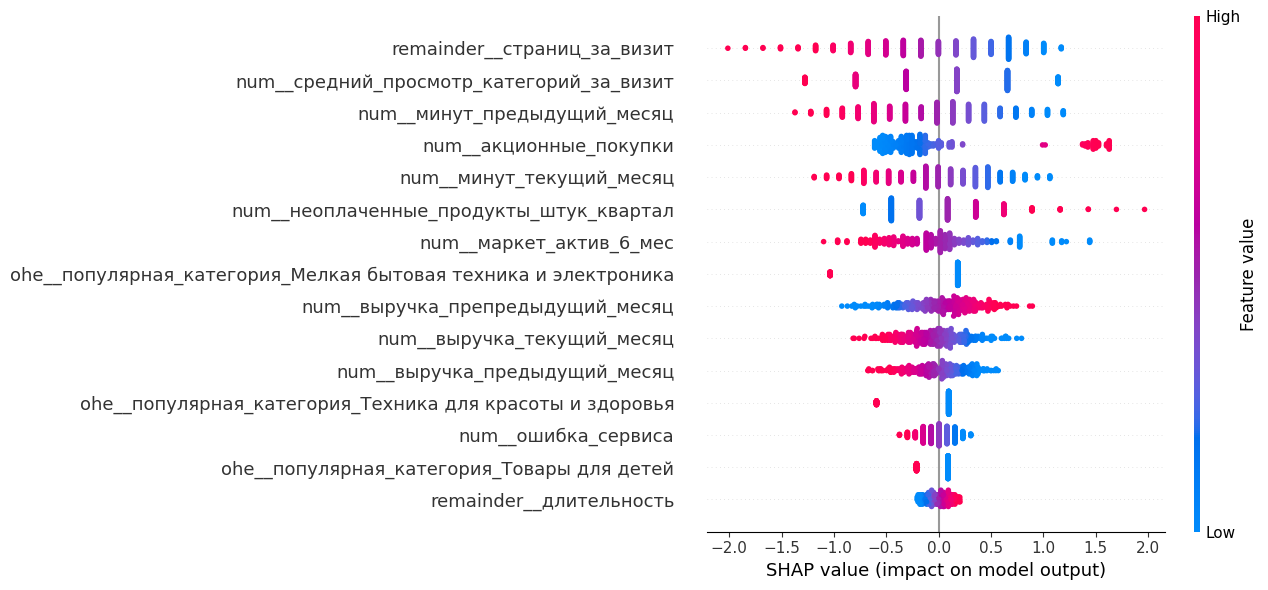

In [84]:
# сохраним экземпляр модели в SHAP
explainer = shap.Explainer(best_model, X_test_df)

# значений SHAP
shap_values = explainer(X_test_df)

# диаграмму плотности рассеяния значений SHAP
shap.summary_plot(shap_values, X_test_df, plot_size=[13, 6], show=False, max_display=15)

Исследуя SHAP‑значения на этой диаграмме, мы можем начать понимать природу взаимоотношений между признаками и спрогнозированным целевым признаком. Например, в случае с признаком **минут_предыдущий_месяц и средний_просмотр_категорий_за_визит**, видно, что SHAP‑значения убывают по мере роста значения признака. Это указывает на то, что более высокие значения этих признаков соответствуют более высокой вероятности принадлежности к классу 0 (прежний уровень).

Видна тут и обратная ситуация, связанная с признаками **акционные_покупки, неоплаченные_продукты_штук_квартал**. Здесь — чем больше значения признаков — больше SHAP‑значения. Это наблюдение указывает на то, что более высокие значения признаков связаны с спрогнозированной вероятностью принадлежности к классу 1 (снизилась).

### Диаграмма `shap.plots.waterfall`

Визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете. Вот как будет 
выглядеть график для 0 шага:

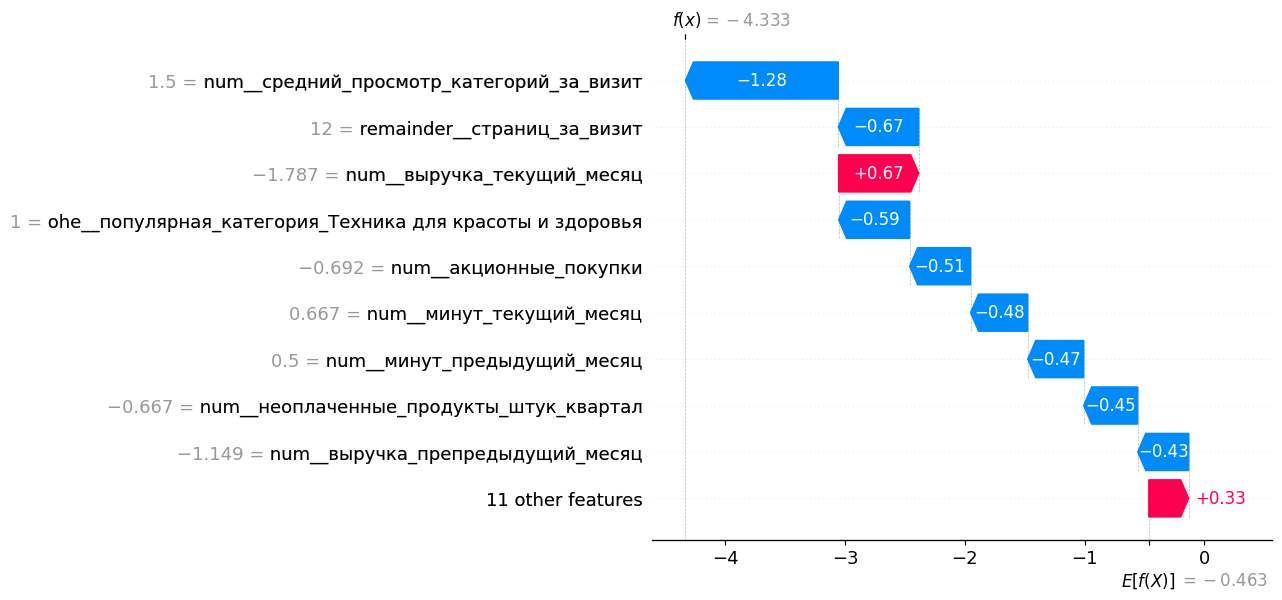

In [85]:
# визуализация SHAP-значений для первого образца
shap.plots.waterfall(shap_values[0])

Ожидаемое прогнозируемое значение, E[f(X)] = -0.461, это значение, найденное на шаге 0. А спрогнозированное значение для первого клиента, f(X) = -4.338, это значение, спрогнозированное для первого образца.

Большинство признаков «перетягивают» предсказание в сторону класса 0. Значение f(x) на графике показывает, к какому классу признак склоняет наблюдение: отрицательные значения говорят о том, что наблюдение скорее относится к классу 0, а положительные — к классу 1.

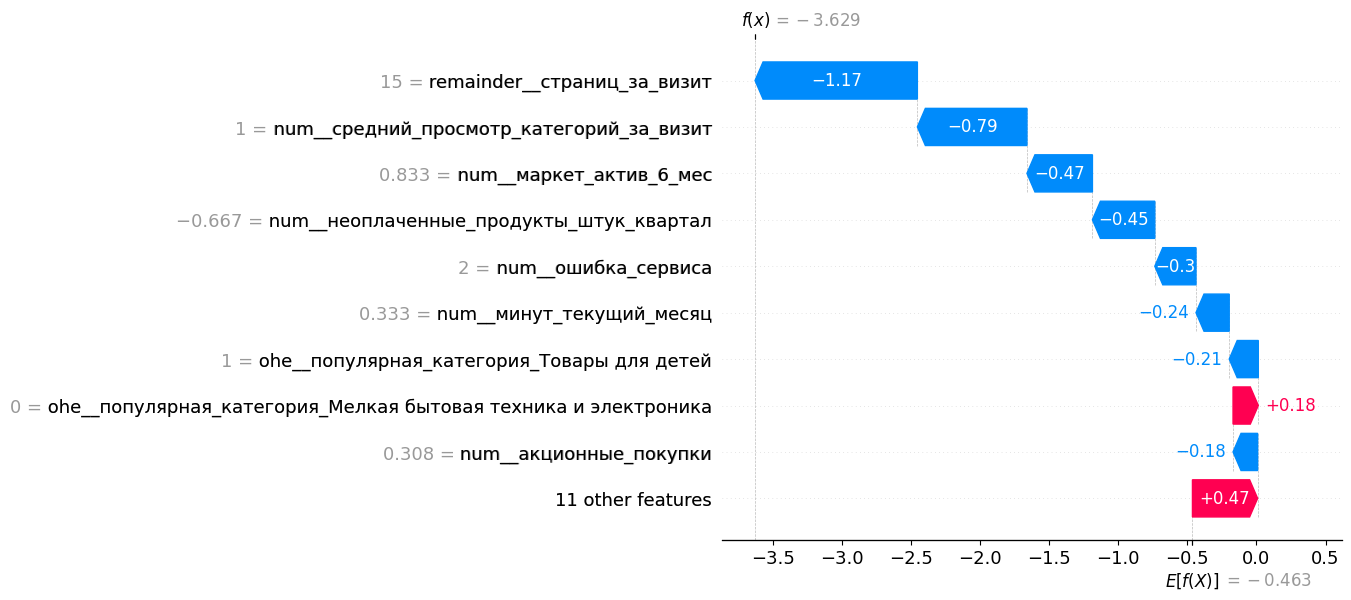

In [86]:
# визуализация SHAP-значений для 15 образца
shap.plots.waterfall(shap_values[15])

Сравнивая SHAP-значения для признаков, описывающих в тестовом наборе данных 1 и 15 клиентов, мы видим то, что они не сильно отличаются друг от друга. В случае с первым наибольшее влияние на его оказал признак **средний_просмотр_категорий_за_визит**. А на спрогнозированное значение для 15 клиента сильнее всего повлиял признак **страниц_за_визит**.

Различия SHAP-значений указывают на то, что в каждом случае каждый из признаков по-особенному влияет на выходные данные модели. Это очень важно понимать для укрепления доверия к процессу принятия решений, реализуемого моделью. Это позволяет обеспечить непредвзятость и беспристрастность результатов.

### Диаграмма `shap.plots.bar`

Чтобы определить, какие признаки являются наиболее важными для прогнозов, выдаваемых моделью, можно использовать столбчатую диаграмму, отражающую результаты усреднения SHAP‑значений по всем наблюдениям. Для расчёта средних берут значения Шепли по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю. 

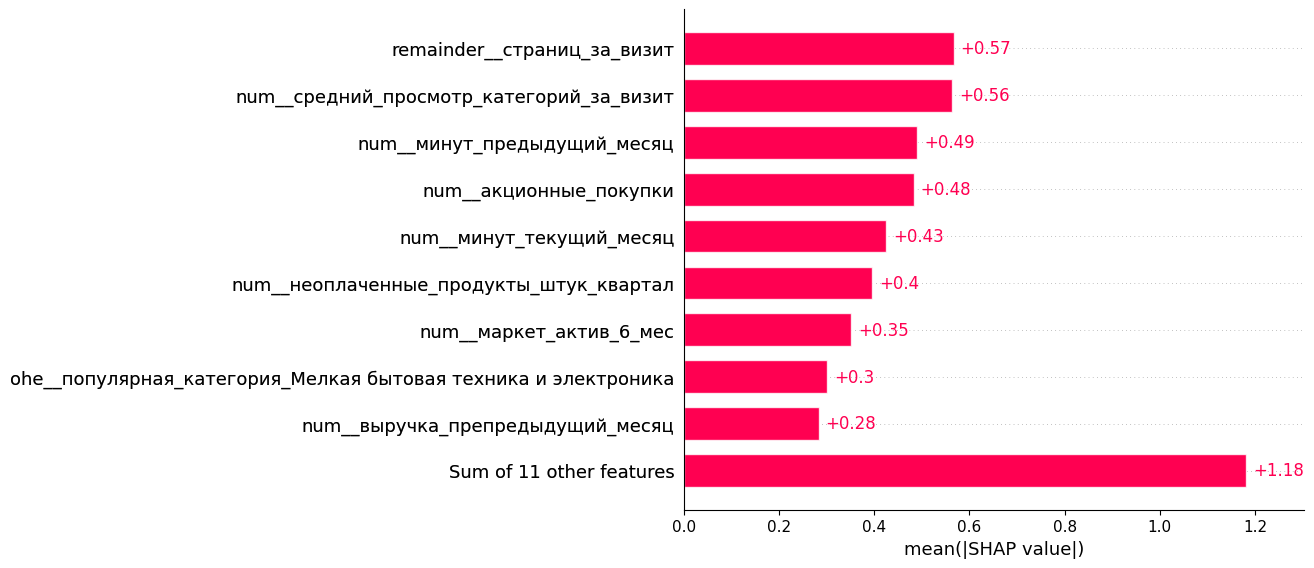

In [87]:
shap.plots.bar(shap_values)

Каждому признаку соответствует свой столбец диаграммы, его размер отражает среднее SHAP‑значение по признаку. На сгенерированном датасете самый большой вес у признаков **страниц_за_визит, средний_просмотр_категорий_за_визит, акционные_покупки**, они сильнее всего влияет на прогнозы модели. Эта информация поможет нам понять то, какие признаки являются наиболее важными в процессе принятия решений, реализуемом моделью.

## Выводы о значимости признаков

1. На основе диаграммы `shap.summary_plot` для модели можно выделить мало значимые признаки:
   - популярная_категория_Мелкая бытова я техника,
   - выручка_препредыдущий_месяц,
   - маркет_актив_6_мес.

2. На основе диаграммы `shap.plots.beeswarm` для модели можно выделить сильно значимые признаки:
   - страниц_за_визит, в сторону 0
   - средний_просмотр_категорий_за_визит, в сторону 0
   - минут_предыдущий_месяц, в сторону 0
   - минут_текущий_месяц, в сторону 0
   - неоплаченные_продукты_штук_квартал,  в сторону 1
   - акционные_покупки, в сторону 1
   - выручка_препредыдущий_месяц, в сторону 1
  
3. При моделировании: можно собрать больше информации, связанной с сильно значимыми признаками и расширить датасет. При принятии бизнес-решений: данные признаки нужно рассмотреть более детально, так как они сильно влияют на принятие решения клиента, покупать или нет. Стоит акцентировать внимание на развитие сильно значимых ризнаков для увеличения продаж.

# Сегментация покупателей

Используем результаты моделирования и данные о прибыльности покупателей. Создадим группы признаков

1. Коммуникация с клиентом, сюда войдут следующие признаки:
   - тип сервиса (тип_сервиса),
   - разрешение на сообщение (разрешить_сообщать),
   - маркетинг 6 месяцев (маркет_актив_6_мес),
   - маркетинг текущего месяца (маркет_актив_тек_мес),
   - длительность истории с клиентом (длительность).

2. Продуктовое поведение, сюда войдут следующие признаки:
   - наиболее частая котегория продукта в заказе (популярная_категория),
   - среднее число простматриваемых категорий продуктов за визит (средний_просмотр_категорий_за_визит),
   - число неоплаченных продуктов в корзине за последние 3 месяца (неоплаченные_продукты_штук_квартал).
  
3. Финансовое поведение, сюда войдут следующие признаки:
   - разница в выручке предыдущего и препредыдущего месяцев (предыдущий_месяц - препредыдущий_месяц),
   - разница в выручке текущего и предыдущего месяцев (текущий_месяц - предыдущий_месяц),
   - выручка в текущем месяце (текущий_месяц).

4. Поведение на сайте, сюда войдут следующие признаки:
   - время на сайте за прошлый год (предыдцщий_месяц + текущий_месяц),
   - время на сайте за предыдущий месяц (предыдущий_месяц),
   - время на сайте за теукщий месяц (текущий_месяц),
   - минут за визит (минут),
   - число страниц за визит (страниц_за_визит),
   - сбой сайта(ошибка_сервиса).
  
Важные признаки по итогу моделирования и SHAP диаграмм: 

1. На основе диаграммы `shap.summary_plot` для модели можно выделить мало значимые признаки:
   - популярная_категория_Мелкая бытова я техника, в сторону 0;
   - выручка_препредыдущий_месяц, в сторону 0;
   - маркет_актив_6_мес, в сторону 0.

2. На основе диаграммы `shap.plots.beeswarm` для модели можно выделить сильно значимые признаки:
   - страниц_за_визит, в сторону 0
   - средний_просмотр_категорий_за_визит, в сторону 0
   - минут_предыдущий_месяц, в сторону 0
   - минут_текущий_месяц, в сторону 0
   - неоплаченные_продукты_штук_квартал,  в сторону 1
   - акционные_покупки, в сторону 1
   - выручка_препредыдущий_месяц, в сторону 1


Для анализа покупателей нас интересуют сильно значимые признаки, склоняющие модель спрогнозировать вероятность класса 1 (покупательская активность снизилась). Это следующие признаки:

- неоплаченные_продукты_штук_квартал;
- акционные_покупки;
- выручка_препредыдущий_месяц.

Данные признаки входят в такие группы признаков как:

1. Продуктовое поведение, сюда войдут следующие признаки:
   - наиболее частая котегория продукта в заказе (популярная_категория),
   - среднее число простматриваемых категорий продуктов за визит (средний_просмотр_категорий_за_визит),
   - число неоплаченных продуктов в корзине за последние 3 месяца (неоплаченные_продукты_штук_квартал).
    
2. Финансовое поведение, сюда войдут следующие признаки:
   - разница в выручке предыдущего и препредыдущего месяцев (предыдущий_месяц - препредыдущий_месяц),
   - разница в выручке текущего и предыдущего месяцев (текущий_месяц - предыдущий_месяц),
   - выручка в текущем месяце (текущий_месяц).

Рассмотрим подробнее эти группы и создадим сегменты с сильно значимыми признаками, вхядищими в них. В таблицы, добавим покупателей с сниженной активностью и прибылью магазина.

In [88]:
# объединим общие данные с прибылью
market_full = (market_full.merge(money, how='left', on='id'))

In [89]:
# создадим пороги вероятности снижения покупательской активности
data = pd.DataFrame(zip(y_test, y_pred_proba),
                    columns = ['y_valid', 'y_pred_proba']).sort_values(by='y_pred_proba', ascending=False)

# пороги
thresholds = [round(i,2) for i in np.linspace(0.5, 1, num = 10, endpoint=False)]

roc_auc_scor = []
for i in thresholds:
    result = roc_auc_score(data['y_valid'],
                     (y_pred_proba >= i).astype(int)
                          )
    roc_auc_scor.append(result)

# добавим столбцы с порогами
columns = []
for i in thresholds:
	columns.append('y_pred_proba'+str(i))
	data['y_pred_proba'+str(i)] = data['y_pred_proba'].apply(
        lambda x: 1 if x >= i else 0)

In [90]:
# предсказания на лучшей модели
y_pred = best_model.predict(X_test_df)

# добавим новые предсказания и прибыль в таблицу
activity_prediction = (
    pd.merge(
        X_test.copy(),
        pd.DataFrame({'предсказания_класса': (y_pred).astype(int),
                      'вероятность_предсказания_класса': y_pred_proba}),
        left_index=True, 
        right_index=True
        )
    .join(money)
    .drop('id', axis=1)
    )

Выделим группы риска для сегментации:
- риск 20%;
- риск 10%.

## Сегмент 1 

На основе **акционные_покупки**. Клиенты с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. С помощью графиков SHAP на основе лучшей модели определили важность этого признака. Отберем покупателей, для которых спрогнозирована вероятность снижения покупательской активности и максимальная доля покупок по акции. Чтобы понять это, сортируем с помощью пороговых значений вероятности и максимальной доли покупок по акции, порог доли возьмем 10%.

In [91]:
# вероятность снижения 80%
len(activity_prediction.query('акционные_покупки >= 0.9 and вероятность_предсказания_класса >= 0.8'))

6

In [92]:
# вероятность снижения 90%
len(activity_prediction.query('акционные_покупки >= 0.9 and вероятность_предсказания_класса >= 0.9'))

3

Как видно по результату в данном сегменте сравнительно небольшое количество клиентов. При 80% точности снижение 
активности у 6 клиентов, при 90% точности - 3 клиента. Но, результат положительный и при большойм объеме данных значения будут на много выше.

## Сегмент 2

Высокая вероятность снижения и максимальная прибыль. Используем вероятность предсказанния метки класса на снижение для понимания разницы в прибыли между клиентами с прежним уровнем.

In [93]:
round(
    activity_prediction
    .query('вероятность_предсказания_класса >= 0.9')
    ['прибыль']
    .sum(), 2
    )

69.92

In [94]:
# контр сегмент
(
    market_full
    .query('покупательская_активность == 0')
    ['прибыль']
    .sample(16, random_state=RANDOM_STATE)
    .sum()
)

65.34

Видно, что разница 7%. Такой результат получен на достаточно маленькой выборке в 16 клиентов, а если их 
будет сотни или тысячи, тогда возможная потеря прибыли из-за снижения активности станет ощутимой для бизнеса.

## Сегмент 3

На основе **неоплаченные_продукты_штук_квартал**. Это общее число неоплаченных товаров в корзине за последние 3 месяца, важность этого признака определили помощью графиков SHAP на основе лучшей модели. Он находится в группе *Продуктовое поведение*, в ней есть смежные признаки **популярная_категория, средний_просмотр_категорий_за_визит**. Используем их для анализа.

In [95]:
# сортировка по средний_просмотр_категорий_за_визит 80%
(
    activity_prediction
    .query('вероятность_предсказания_класса >= 0.8')
    ['средний_просмотр_категорий_за_визит']
    .value_counts()
)

средний_просмотр_категорий_за_визит
3    7
2    7
1    4
4    3
5    1
Name: count, dtype: int64

In [96]:
# сортировка по средний_просмотр_категорий_за_визит 90%
(
    activity_prediction
    .query('вероятность_предсказания_класса >= 0.9')
    ['средний_просмотр_категорий_за_визит']
    .value_counts()
)

средний_просмотр_категорий_за_визит
3    6
2    5
1    3
4    2
Name: count, dtype: int64

Судя по таблицам видно, что чаще всего встречается значение просмотра в 3 страницы.

In [97]:
# сортировка по популярная_категория 80%
(
    activity_prediction
    .query('вероятность_предсказания_класса >= 0.8')
    ['популярная_категория']
    .value_counts()
)

популярная_категория
Товары для детей                        8
Кухонная посуда                         4
Домашний текстиль                       4
Косметика и аксессуары                  2
Мелкая бытовая техника и электроника    2
Техника для красоты и здоровья          2
Name: count, dtype: int64

In [98]:
# сортировка по популярная_категория 90%
(
    activity_prediction
    .query('вероятность_предсказания_класса >= 0.9')
    ['популярная_категория']
    .value_counts()
)

популярная_категория
Товары для детей                        7
Косметика и аксессуары                  2
Мелкая бытовая техника и электроника    2
Кухонная посуда                         2
Техника для красоты и здоровья          2
Домашний текстиль                       1
Name: count, dtype: int64

Максимальное количество клиентов в категории **Товары для детей**.

## Сегмент 4

Динамика выручки, рассмотрим прибыль по месяцам в признаке **популярная_категория**.

In [99]:
(
    activity_prediction
    .groupby(['популярная_категория'], as_index=False)
    .agg({'выручка_препредыдущий_месяц' : 'sum',
          'выручка_предыдущий_месяц' : 'sum',
          'выручка_текущий_месяц' : 'sum'})
    .set_index('популярная_категория')
    .sort_values(by='выручка_препредыдущий_месяц', ascending=False)
)

выручка_препредыдущий_месяц  \
популярная_категория                                                
Товары для детей                                         127140.5   
Домашний текстиль                                        110480.0   
Косметика и аксессуары                                    87245.5   
Кухонная посуда                                           54223.5   
Техника для красоты и здоровья                            32693.0   
Мелкая бытовая техника и электроника                      28391.0   

                                      выручка_предыдущий_месяц  \
популярная_категория                                             
Товары для детей                                      124484.0   
Домашний текстиль                                      98449.0   
Косметика и аксессуары                                 79558.0   
Кухонная посуда                                        45928.0   
Техника для красоты и здоровья                         31952.0   
Мелкая бытовая техника и электроника                   22913.0   

                                      выручка_текущий_месяц  
популярная_категория                                         
Товары для детей                                   134650.6  
Домашний текстиль                                  117414.2  
Косметика и аксессуары                              91275.5  
Кухонная посуда                                     57586.6  
Техника для красоты и здоровья                      35023.9  
Мелкая бытовая техника и электроника                30166.8

Определенно лидирует категория *Товары для детей*, а *Мелкая бытовая техника и электроника* 
сильно проседает по отношению к остальным. Скорее всего это связано с длинным жизненным циклом товаров.

## Сегмент 5

В данном сегменте комбинируем предыдущие для понимания общей тенденции снижения покупательской активности. Используем установленные группы риска. Создадим финальную таблицу клиентов с сниженной активностью.

In [100]:
# риск 20%
segment_80 = (
    activity_prediction
    .query('вероятность_предсказания_класса >= 0.8')
    .groupby('популярная_категория', as_index=False)
    .agg({
        'вероятность_предсказания_класса' : 'count',
        'прибыль' : 'sum',
        'выручка_препредыдущий_месяц' : 'sum',
        'выручка_предыдущий_месяц' : 'sum',
        'выручка_текущий_месяц' : 'sum',
        'неоплаченные_продукты_штук_квартал' : 'sum',
        'средний_просмотр_категорий_за_визит' : 'sum',
        'акционные_покупки' : 'sum'
        })
    .set_index('популярная_категория')
    .sort_values(by='прибыль', ascending=False)
    .rename(columns={'вероятность_предсказания_класса': 'количество_клиентов'})
    )

segment_80['выручка_3_месяца'] = ((
    segment_80['выручка_препредыдущий_месяц'] +
    segment_80['выручка_предыдущий_месяц'] +
    segment_80['выручка_текущий_месяц']
    ) * segment_80.количество_клиентов
                                 )

segment_80.drop(
    [
        'выручка_препредыдущий_месяц',
        'выручка_предыдущий_месяц', 
        'выручка_текущий_месяц'
    ], axis=1
    ).T

популярная_категория                 Товары для детей  Кухонная посуда  \
количество_клиентов                              8.00             4.00   
прибыль                                         36.32            17.54   
неоплаченные_продукты_штук_квартал              30.00            22.00   
средний_просмотр_категорий_за_визит             24.00             8.00   
акционные_покупки                                4.16             2.61   
выручка_3_месяца                            906680.00        244737.20   

популярная_категория                 Домашний текстиль  \
количество_клиентов                               4.00   
прибыль                                          15.48   
неоплаченные_продукты_штук_квартал               11.00   
средний_просмотр_категорий_за_визит              10.00   
акционные_покупки                                 2.00   
выручка_3_месяца                             245601.60   

популярная_категория                 Техника для красоты и здоровья  \
количество_клиентов                                            2.00   
прибыль                                                        9.40   
неоплаченные_продукты_штук_квартал                            11.00   
средний_просмотр_категорий_за_визит                            5.00   
акционные_покупки                                              1.25   
выручка_3_месяца                                           56387.00   

популярная_категория                 Мелкая бытовая техника и электроника  \
количество_клиентов                                                  2.00   
прибыль                                                              8.13   
неоплаченные_продукты_штук_квартал                                   7.00   
средний_просмотр_категорий_за_визит                                  5.00   
акционные_покупки                                                    0.63   
выручка_3_месяца                                                 63021.00   

популярная_категория                 Косметика и аксессуары  
количество_клиентов                                    2.00  
прибыль                                                8.05  
неоплаченные_продукты_штук_квартал                     6.00  
средний_просмотр_категорий_за_визит                    4.00  
акционные_покупки                                      0.56  
выручка_3_месяца                                   64464.20

In [101]:
# риск 10%
segment_90 = (
    activity_prediction
    .query('вероятность_предсказания_класса >= 0.9')
    .groupby('популярная_категория', as_index=False)
    .agg({
        'вероятность_предсказания_класса' : 'count',
        'прибыль' : 'sum',
        'выручка_препредыдущий_месяц' : 'sum',
        'выручка_предыдущий_месяц' : 'sum',
        'выручка_текущий_месяц' : 'sum',
        'неоплаченные_продукты_штук_квартал' : 'sum',
        'средний_просмотр_категорий_за_визит' : 'sum',
        'акционные_покупки' : 'sum'
        })
    .set_index('популярная_категория')
    .sort_values(by='прибыль', ascending=False)
    .rename(columns={'вероятность_предсказания_класса': 'количество_клиентов'})
    )

segment_90['выручка_3_месяца'] = ((
    segment_80['выручка_препредыдущий_месяц'] +
    segment_80['выручка_предыдущий_месяц'] +
    segment_80['выручка_текущий_месяц']
    ) * segment_90.количество_клиентов
            
                                 )
segment_90.drop(
    [
        'выручка_препредыдущий_месяц',
        'выручка_предыдущий_месяц', 
        'выручка_текущий_месяц'
    ], axis=1
    ).T

популярная_категория                 Товары для детей  \
количество_клиентов                              7.00   
прибыль                                         31.45   
неоплаченные_продукты_штук_квартал              30.00   
средний_просмотр_категорий_за_визит             19.00   
акционные_покупки                                3.17   
выручка_3_месяца                            793345.00   

популярная_категория                 Техника для красоты и здоровья  \
количество_клиентов                                            2.00   
прибыль                                                        9.40   
неоплаченные_продукты_штук_квартал                            11.00   
средний_просмотр_категорий_за_визит                            5.00   
акционные_покупки                                              1.25   
выручка_3_месяца                                           56387.00   

популярная_категория                 Кухонная посуда  \
количество_клиентов                             2.00   
прибыль                                         8.57   
неоплаченные_продукты_штук_квартал             11.00   
средний_просмотр_категорий_за_визит             5.00   
акционные_покупки                               1.33   
выручка_3_месяца                           122368.60   

популярная_категория                 Мелкая бытовая техника и электроника  \
количество_клиентов                                                  2.00   
прибыль                                                              8.13   
неоплаченные_продукты_штук_квартал                                   7.00   
средний_просмотр_категорий_за_визит                                  5.00   
акционные_покупки                                                    0.63   
выручка_3_месяца                                                 63021.00   

популярная_категория                 Косметика и аксессуары  Домашний текстиль  
количество_клиентов                                    2.00               1.00  
прибыль                                                8.05               4.32  
неоплаченные_продукты_штук_квартал                     6.00               4.00  
средний_просмотр_категорий_за_визит                    4.00               1.00  
акционные_покупки                                      0.56               0.33  
выручка_3_месяца                                   64464.20           61400.40

По итогу получаем лидера по всем показателям **Товары для детей**, здесь и максимальное количество клиентов с сниженной 
активностью и важнейшая составляющая бизнеса - самая большая выручка за 3 месяца среди всех категорий.

## Персонализированные предложения

Анализируя финальную таблицу, можно сделать вывод: необходимо мотивировать клиентов покупать 
больше товаров в категории **Товары для детей**. Например, можно предложить следующую рекомендации: 

- добавить различные акции, например: если чек за 1 покупку больше 5000 р, клиент может принять участие в розыгрыше билетов в местный зоопарк или океанариум;
- главные покупатели товаров для детей - родители, бабушки и дедушки. Рекламу товара нужно акцентировать на эту аудиторию;
- создайть страницы в социальных сетях с медиа, которое понравится целевой аудитории. Размещяем уроки по воспитанию, разные посты и обязательно фото и видео товаров;
- инфлюенс-маркетинг: партнерство с известными актерами, блогерами, культурными деетелями, которые покажут товар общественности. Таким образом можно расположить компанию, продающую товар к потребителю с помощью известных личностей;
- добавить праздничные скидки и акции по сезонности (Новый Год, День защиты детей, День семьи);
- обязательно настроить SEO-оптимизацию.

# Общий вывод

В данном проекте выполнили следующие задачи.

**По ходу предобработки:**
- удалили дупликаты,
- исправили названия столбцов,
- изменили формат данных в стоблцах для оптимизации,
- удалили аномалию,
- исправили опечатку,
- потери после предобработки примерно 0.1%.

**На этапе исследовательского анализа данных выделили такие моменты:**

- есть выбросы в маркет_актив_6_мес у Снизилась до 1.75 от 6.5 и Прежний уровень до 1.6. У покупателей с сниженной активностью меньше коммуникаций с компанией.
- есть выбросы в маркет_актив_тек_мес у Прежний уровень до 3.1 от 4.9. По графикам заметно, что компания взаимодействовала в текущем месяце с клиентами с сниженной активность меньше, чем с клиентами с прежним уровнем. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего на каждого клиента.
- в длительность аналогично, клиенты с сниженной активностью не так давно зарегистрированы на сайте.
- есть выбросы в акционные_покупки у Прежний уровень от 0.41 Клиенты с сниженной активностью за последние 6 месяцев менше учавствовали в акцонных покупках. В районе единицы у группы снижена активность всплеск показателей, возможно была распродажа или большая акция на товары.
- есть выбросы в средний_просмотр_категорий_за_визит у Снизилась от 5. У этой же категории меньше среднее просмотра.
- есть выбросы в неоплаченные_продукты_штук_квартал у Снизилась от 9 и Прежний уровень от 7. Логично, что у тех кто меньше покупает, меньше неоплаченных товаров.
- в ошибка_сервиса у Снизилась меньше сбоев.
- есть выбросы в страниц_за_визит у Снизилась от 12.6 и Прежний уровень от 20. Аналогично, как везде, клиенты с сниженной активностью за один визит на сайт открывают меньше страниц.
- есть выбросы в выручка до 3450 и от 6450, так же есть аномалия. Получается предыдущий месяц для компании в плане выручки был самый лучший.
- есть выбросы в прибыль до 1.4 и от 6.65 Препредыдущий месяц мене прибыльный, текущий лучший по прибыли.

**На этапе корреляционного анализа выделили следующие моменты:**

После построение диаграммы рассеяния количественных признаков можно сделать следующие выводы:
- в основном имеют хорошую дисперсию;
- в **акционные_покупки** образовалось 2 кластера по отношению к категории **разрешить_сообщать**, до 0.38 и от 0.85;
- то же самое наблюдаем в **акционные_покупки** по отношению к категории **популярная_категория**, до 0.38 и от 0.85.

Судя по графикам распределения количественных признаков можно сделать следующие выводы:
- в основном количественные признаки имеют нормальное распределение;
- присутствуют отклонения от нормальности у **акционные_покупки, неоплаченные_продукты_штук_квартал, страниц_за_визит**;
- значит оценим корреляцию целевого признака с вхордящими с помощью библиотеки phik, потому что целевой категориальный.

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:
- теплые тона говорят о сильной линейной зависимости, а холодные — о слабой;
- корреляция между целевым и остальными достаточно слабая, кроме **минут_предыдущий_месяц, страниц_за_визит, акционные_покупки**;
- мультиколлинеарность отсутствует, так как порог для подтверждения 0.9-0.95;
- утечки целевого признака через входящие не наблюдается.

После построение корреляционной матрицы входящих признаков без целевого можно сделать следующие выводы:
- выделяется пара **выручка_текущий_месяц и выручка_препредыдущий_месяц**, они находятся в одном группе признаков *Финансовое поведение*;
- мультиколлинеарность отсутствует.

**На этапе использования пайплайна**:

Выделили лучшую модель на основе подбора гиперпараметров `RandomizedSearchSV`: `LogisticRegression`, с параметрами `solver='liblinear', max_iter=300` и скайлером `StandardScaler`.

**Провели финальное тестирование лучшей модели**:

По итогу подготовки данных модель LogisticRegression имеет показатель метрики качества классификации `ROC-AUC = 0.92`

**Сделали выводы о значимости признаков:**

1. На основе диаграммы `shap.summary_plot` для модели можно выделить мало значимые признаки:
    - популярная_категория_Мелкая бытова я техника,
    - выручка_препредыдущий_месяц,
    - маркет_актив_6_мес.
    
2. На основе диаграммы `shap.plots.beeswarm` для модели можно выделить сильно значимые признаки:
    - страниц_за_визит, в сторону 0
    - средний_просмотр_категорий_за_визит, в сторону 0
    - минут_предыдущий_месяц, в сторону 0
    - минут_текущий_месяц, в сторону 0
    - неоплаченные_продукты_штук_квартал, в сторону 1
    - акционные_покупки, в сторону 1
    - выручка_препредыдущий_месяц, в сторону 1
    
3. При моделировании: можно собрать больше информации, связанной с сильно значимыми признаками и расширить датасет. При принятии бизнес-решений: данные признаки нужно рассмотреть более детально, так как они сильно влияют на принятие решения клиента, покупать или нет. Стоит акцентировать внимание на развитие сильно значимых ризнаков для увеличения продаж.

**Сделали сегментацию покупателей:**

На основе важных признаков, склоняющих модель спрогнозировать вероятность класса 1 (покупательская активность снизилась). Это следующие признаки:
- неоплаченные_продукты_штук_квартал;
- акционные_покупки;
- выручка_препредыдущий_месяц.

По итогу выявили лидера по всем показателям **Товары для детей**, здесь и максимальное количество клиентов с сниженной активностью и важнейшая составляющая бизнеса - самая большая выручка за 3 месяца среди всех категорий.

**Разработали персонализированные предложения:**

Анализируя финальную таблицу, можно сделать вывод: необходимо мотивировать клиентов покупать больше товаров в категории **Товары для детей**. Например, можно предложить следующую рекомендации: 
- добавить различные акции, например: если чек за 1 покупку больше 5000 р, клиент может принять участие в розыгрыше билетов в местный зоопарк или океанариум;
- главные покупатели товаров для детей - родители, бабушки и дедушки. Рекламу товара нужно акцентировать на эту аудиторию;
- создать страницы в социальных сетях с медиа, которое понравится целевой аудитории. Разместить уроки по воспитанию, разные посты и обязательно фото и видео товаров;
- инфлюенс-маркетинг: партнерство с известными актерами, блогерами, культурными деетялями, которые покажут товар общественности. Таким образом можно расположить компанию, продающую товар к потребителю с помощью известных личностей;
- добавить праздничные скидки и акции по сезонности (Новый Год, День защиты детей, День семьи);
- обязательно настроить SEO-оптимизацию.